# Реализация нейронной сети из туториала PyTorch используя библиотеку NumPy вместо фреймворка PyTorch

## Импорт необходимых библиотек и зависимостей

In [289]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from PIL import Image
import time
import statistics
import random
import warnings
from dataclasses import dataclass, field
from typing import Optional, List, Dict, Tuple, Any, Generator, Union, Callable
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics import Precision, Recall, F1Score

warnings.filterwarnings(action='once')

## Пример работы простого MatPlotLib кода

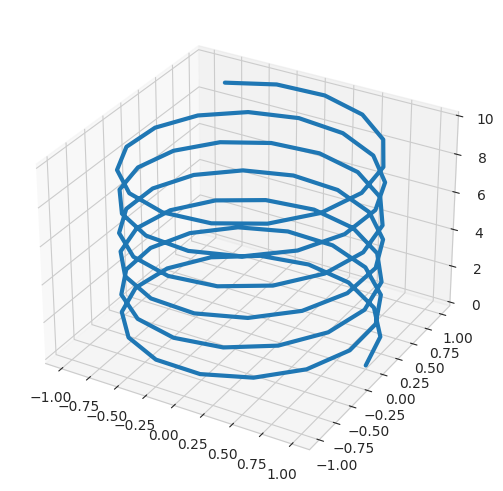

In [215]:
sns.set_style("whitegrid")

OMEGA: int = 4

Z1: np.ndarray = np.linspace(0, 10, 100)
X1: np.ndarray = np.cos(OMEGA * Z1)
Y1: np.ndarray = np.sin(OMEGA * Z1)

plt.figure(figsize=(6, 5))
axes = plt.axes(projection="3d")
axes.plot3D(X1, Y1, Z1, lw=3)
# keeps padding between figure elements
plt.tight_layout()
plt.show()

## Пишем простую нейростеть на PyTorch

### Инициализуем классы и функции

### Загружаем тренировочные и тестовые данные

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

### Получаем пример работы с датасетом

/home/yamshchikov/ML_practice/Torchvision_core_project/MLvenv/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


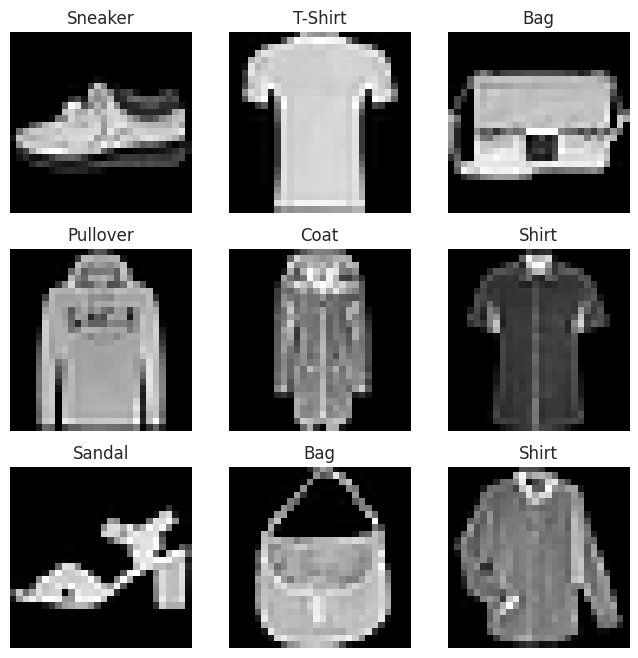

In [217]:
labels_map: Dict[int, str] = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx: int = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Инициализация train и test DataLoader

In [218]:
batch_size: int = 64

# Create data loaders.
train_dataloader: DataLoader = DataLoader(
    training_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=True
)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Проверка доступности CUDA и CPU

In [219]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device: str = "cuda"  # Use GPU if available
    device_name: str = torch.cuda.get_device_name(0)  # Get GPU name
    print(f"Using CUDA device: {device_name}")
else:
    device = "cpu"  # Use CPU if no GPU is available
    print("Using CPU device")

print(f"Using {device} device")

Using CUDA device: NVIDIA RTX 4000 SFF Ada Generation
Using cuda device


### Объявление класса простой PyTorch модели

In [220]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model: NeuralNetwork = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Объявление класса для создания кастомного датасета

In [221]:
class CustomImageDataset(Dataset):
    def __init__(
        self, 
        annotations_file: str, 
        img_dir: str, 
        transform=None, 
        target_transform=None
    ) -> None:
        self.img_labels: pd.DataFrame = pd.read_csv(annotations_file)
        self.img_dir: str = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_labels)

    def __getitem__(
        self, 
        idx: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path: str = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image: torch.Tensor = read_image(img_path)
        label: torch.Tensor = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Отображение картинки и подписи.

In [222]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


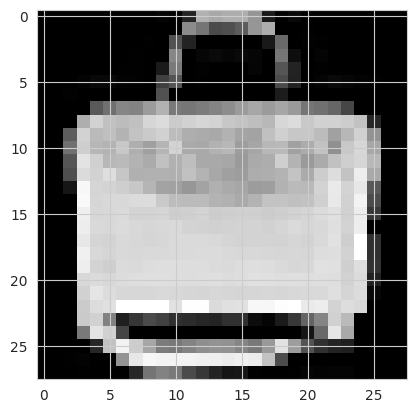

Label: 8


In [223]:
img = train_features[0].squeeze()
label: int = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [224]:
img.dtype

torch.float32

### Инициализация loss-функции и SGD оптимизатора.

In [225]:
learning_rate: float = 1e-3
loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: torch.optim.SGD = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate
)

In [226]:
loss_fn

CrossEntropyLoss()

In [227]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Объявление train функции.

In [228]:
def train(
    dataloader: DataLoader, 
    model: Any, 
    loss_fn: Any, 
    optimizer: Any
) -> None:
    size: int = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss: float = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Объявление test функции.

In [229]:
def test(
    dataloader: DataLoader, 
    model: Any, 
    loss_fn: Any
) -> None:
    size: int = len(dataloader.dataset)
    num_batches: int = len(dataloader)
    model.eval()
    test_loss: float
    correct: int
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Основной код обучения PyTorch модели.

In [160]:
loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: torch.optim.SGD = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate
)

epochs: int = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.908715  [   64/60000]
loss: 0.906582  [ 6464/60000]
loss: 0.756893  [12864/60000]
loss: 0.783836  [19264/60000]
loss: 0.927171  [25664/60000]
loss: 0.775381  [32064/60000]
loss: 0.883036  [38464/60000]
loss: 0.931873  [44864/60000]
loss: 0.864029  [51264/60000]
loss: 0.571051  [57664/60000]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.774831 

Epoch 2
-------------------------------
loss: 0.837163  [   64/60000]
loss: 0.775330  [ 6464/60000]
loss: 0.761669  [12864/60000]
loss: 0.731069  [19264/60000]
loss: 0.754878  [25664/60000]
loss: 0.773810  [32064/60000]
loss: 0.824078  [38464/60000]
loss: 0.765644  [44864/60000]
loss: 0.767986  [51264/60000]
loss: 0.835758  [57664/60000]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.752051 

Epoch 3
-------------------------------
loss: 0.655123  [   64/60000]
loss: 0.528100  [ 6464/60000]
loss: 0.701274  [12864/60000]
loss: 0.702206  [19264/60000]
loss: 0.804003  [25664/60000]
loss: 0.844265  [32064/600

### Сохранение PyTorch модели в 3-х разных форматах.

In [161]:
joblib_model_file: str = "../models/model_torch.joblib"
pickle_model_file: str = "../models/model_torch.pkl"
torch_model_file: str = "../models/model_torch.pth"
joblib.dump(model.state_dict(), joblib_model_file)
torch.save(model.state_dict(), torch_model_file)
with open(pickle_model_file, "wb") as file:
    pickle.dump(model.state_dict(), file)
print(f"Saved PyTorch Model State to {torch_model_file}")
print(f"Saved Joblib Model State to {joblib_model_file}")
print(f"Saved Pickle Model State to {pickle_model_file}")

Saved PyTorch Model State to ../models/model_torch.pth
Saved Joblib Model State to ../models/model_torch.joblib
Saved Pickle Model State to ../models/model_torch.pkl


### Пример загрузки PyTorch модели.

In [162]:
model: NeuralNetwork = NeuralNetwork().to(device)
model.load_state_dict(torch.load(
    torch_model_file, 
    weights_only=True
))

<All keys matched successfully>

### Выполнение предсказания с помощью PyTorch модели.

In [230]:
classes: List[str] = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## 🎯🏆Переписывание нейронной сети из примера PyTorch на Numpy

### Инициализация глобальных параметров

In [270]:
@dataclass(frozen=True)
class Constants:
    """Глобальные константы для нейронной сети"""
    input_size: int = 28 * 28
    segment_size: int = 28
    hidden_size: int = 512
    output_size: int = 10
    learning_rate: float = 1e-3
    tolerance: float = 1e-15
    epochs: int = 200
    batch_size: int = 64
    report_interval: int = 100
    num_images: int = 9
    num_classes: int = 10
    pixel_value: float = 255.0
    filename: Optional[str] = field(default=None, init=False)

    def __post_init__(self) -> None:
        object.__setattr__(self, 'filename', "../models/numpy_model.pkl")

MY_CONSTANTS = Constants()

### Загрузка словаря с подписями

In [271]:
# Словарь меток классов FashionMNIST
labels_map: Dict[int, str] = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## Вспомогательные функции

### Функция для загрузки датасета

In [272]:
"""
[EN] Function that loads FashionMNIST dataset and preprocesses it for NumPy-based Neural Network.
[RU] Функция, которая загружает FashionMNIST датасет и подготавливает его для NumPy-based Neural Network
"""
def load_fashion_mnist(
    train: bool = True,
    flatten: bool = True,
    normalize: bool = True
) -> Tuple[Optional[np.ndarray[np.float32]], Optional[np.ndarray[np.int64]]]:
    """
    Загрузка FashionMNIST датасета и предобработка для NumPy нейросети.
    
    Args:
        train: Загружать тренировочный (True) или тестовый (False) набор
        flatten: Преобразовывать изображения в плоский вектор
        normalize: Нормализовать пиксели к [0, 1]
    
    Returns:
        Tuple[images, labels] или (None, None) при ошибке
    """
    try:
        data: datasets.FashionMNIST = datasets.FashionMNIST(
            root="../data", 
            train=train, 
            download=True
        )
    except Exception as e:
        print(f"Error loading FashionMNIST: {e}")
        return None, None
    num_samples: int = len(data)
    img_shape: Tuple[int, int] = data[0][0].size
    if flatten:
        img_size: int = img_shape[0] * img_shape[1]
        images: np.ndarray[np.float32] = np.zeros(
            (num_samples, img_size), 
            dtype=np.float32
        )
    else:
        images = np.zeros(
            (num_samples, img_shape[0], img_shape[1]), 
            dtype=np.float32
        )
    labels: np.ndarray[np.int64] = np.zeros(num_samples, dtype=np.int64)

    for idx, (img, label) in enumerate(data):
        img_np: np.ndarray[np.float32] = np.array(img, dtype=np.float32)
        if normalize:
            img_np /= MY_CONSTANTS.pixel_value
        if flatten:
            img_np = img_np.flatten()
        images[idx] = img_np
        labels[idx] = label
    return images, labels

### Функция для создания батчей изображений

In [273]:
"""
[EN] Function that creates batches of data from NumPy arrays.
[RU] Функция для создания серий из данных на основе массивов NumPy
"""
def create_batches(
    images: npt.NDArray[np.float32],
    labels: npt.NDArray[np.int64],
    batch_size: int = MY_CONSTANTS.batch_size,
    shuffle: bool = True,
    reshape: bool = True
) -> Generator[Tuple[npt.NDArray[np.float32], npt.NDArray[np.int64]], None, None]:
    """
    Создание батчей из NumPy массивов.
    
    Args:
        images: Массив изображений
        labels: Массив меток
        batch_size: Размер батча
        shuffle: Перемешивать данные
        reshape: Изменять форму для сверточного формата
    
    Yields:
        Tuple[batch_images, batch_labels]
    """
    num_samples: int = images.shape[0]
    if shuffle:
        permutation: npt.NDArray[np.int64] = np.random.permutation(num_samples)
        images = images[permutation]
        labels = labels[permutation]
    for i in range(0, num_samples, batch_size):
        batch_images: npt.NDArray[np.float32] = images[i:i + batch_size]
        batch_labels: npt.NDArray[np.int64] = labels[i:i + batch_size]
        if reshape:
            batch_images = batch_images.reshape(
                -1,
                MY_CONSTANTS.segment_size,
                MY_CONSTANTS.segment_size
            )
            batch_images = np.expand_dims(batch_images, axis=1)
        yield batch_images, batch_labels

### Функция для кодирования подписей

In [274]:
"""
[EN] Function that encodes the labels.
[RU] Функция для кодирования подписей
"""
def label_encode(
    labels: npt.NDArray[np.int64],
    num_classes: int = MY_CONSTANTS.num_classes
) -> npt.NDArray[np.float32]:
    """
    One-hot кодирование меток.
    
    Args:
        labels: Массив меток [batch_size]
        num_classes: Количество классов
    
    Returns:
        One-hot encoded массив [batch_size, num_classes]
    """
    encoded_labels: npt.NDArray[np.float32] = np.zeros(
        (len(labels), num_classes), 
        dtype=np.float32
    )
    encoded_labels[np.arange(len(labels)), labels] = 1
    return encoded_labels

## Визуализация

### Функция для отображения изображений датасета

In [275]:
"""
[EN] Function that display a grid of random images from the dataset.
[RU] Функция для вывода графика рандомных изображений из  датасета
"""
def display_random_images(
    images: npt.NDArray[np.float32],
    labels: npt.NDArray[np.int64],
    labels_map: Dict[int, str],
    num_images: int = MY_CONSTANTS.num_images
) -> None:
      """Отображение сетки случайных изображений из датасета."""
      figure: plt.Figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, num_images + 1):
        sample_idx: int = np.random.randint(0, len(images))
        img: npt.NDArray[np.float32] = images[sample_idx]
        label: int = labels[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(
            img.reshape(MY_CONSTANTS.segment_size,
                        MY_CONSTANTS.segment_size
            ),
            cmap="gray"
        )
      plt.show()

### Функция для вывода графика тренировки

In [276]:
"""
[EN] Function that prints a cycle graph.
[RU] Функция для вывода графика-тренировки в цикле
"""
def print_cycle_graph(
    batch_indices: List[int],
    batch_losses: List[float],
    epoch_count: int
) -> None:
    """Отображение графика потерь по батчам."""
    plt.figure(figsize=(10, 6))
    plt.plot(batch_indices, batch_losses, label="Training Loss - Batches", color="purple")
    plt.xlabel("Batch Index")
    plt.ylabel("Average Loss")
    plt.title(f"Training Loss - Epoch {epoch_count}")
    plt.grid(True, linestyle='--', linewidth=1.4)
    plt.xticks(fontsize=12)
    plt.yticks(range(1, 11), fontsize=12)
    plt.legend(["Training Loss - Batches"])
    plt.show()

### Функция для построения графика функции потерь

In [277]:
"""
[EN] Function that returns a loss-function graph.
[RU] Функция для вывода графика функции потерь
"""
def print_result_graph(
    avg_loss_train: List[float],
    avg_loss_test: List[float]
) -> None:
  """Отображение графика функции потерь на train и test."""
  epochs: range = range(1, len(avg_loss_train) + 1)
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, avg_loss_train, label="All Training Loss", color='green') # Plot all train losses
  plt.plot(epochs, avg_loss_test, label="All Test Loss", color='blue') # Plot all test losses
  plt.xlabel("Epoch")
  plt.ylabel("Average Loss")
  plt.title("Final Plot: Total Loss per Epoch")
  plt.grid(True, linestyle='--', linewidth = "1.4")
  plt.xticks(range(1, len(avg_loss_train) + 1, 10), fontsize=12)
  plt.yticks(np.arange(0.2, 1.5, 0.1), fontsize=12)
  plt.legend()
  plt.show()

### Функция для вывода графика точности

In [278]:
"""
[EN] Function that returns a test-accuracy graph.
[RU] Функция для вывода графика точности на тесте
"""
def print_accuracy_graph(
    accuracy_test: List[float],
    avg_loss_train: List[float]
) -> None:
    """Отображение графика точности на тестовых данных."""
    epochs: range = range(1, len(avg_loss_train) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracy_test, color="red", label="Accuracy on Test data")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy result")
    plt.title("Accuracy result on Test data per Epoch")
    plt.grid(True, linestyle='--', linewidth=1.4)
    plt.xticks(range(1, len(avg_loss_train) + 1, 10), fontsize=12)
    plt.yticks(np.arange(0.6, 0.9, 0.01), fontsize=12)
    plt.legend(loc='lower right')
    plt.show()

### Функция для сравнения кастомной реализации с PyTorch

In [279]:
def compare_with_pytorch(
    numpy_losses: List[float],
    pytorch_losses: List[float],
    numpy_acc: List[float],
    pytorch_acc: List[float]
) -> None:
    """Сравнение NumPy и PyTorch реализаций."""
    epochs: range = range(1, len(numpy_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График Loss
    ax1.plot(epochs, numpy_losses, 'b-', label='NumPy Loss', linewidth=2)
    ax1.plot(epochs, pytorch_losses, 'r--', label='PyTorch Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Comparison: NumPy vs PyTorch')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # График Accuracy
    ax2.plot(epochs, numpy_acc, 'b-', label='NumPy Accuracy', linewidth=2)
    ax2.plot(epochs, pytorch_acc, 'r--', label='PyTorch Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Comparison: NumPy vs PyTorch')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

### Графики для анализа точности оригинального Torch и кастомного NumPy класса

In [280]:
def print_all_metrics_graphs(metrics: Dict[str, List[float]]) -> None:
    """
    Отображение всех графиков метрик обучения.
    
    Args:
        metrics: Словарь с метриками из train()
    """
    epochs = metrics['epochs']
    
    # 1. График Loss (Train vs Test)
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics['train_losses'], 'g-', label='Train Loss', marker='o')
    plt.plot(epochs, metrics['test_losses'], 'b-', label='Test Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Cross-Entropy Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 2. График Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics['train_accuracies'], 'g-', label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics['test_accuracies'], 'b-', label='Test Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 3. График MSE
    plt.subplot(2, 3, 3)
    plt.plot(epochs, metrics['train_mses'], 'g-', label='Train MSE', marker='o')
    plt.plot(epochs, metrics['test_mses'], 'b-', label='Test MSE', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 4. График Precision
    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics['train_precisions'], 'g-', label='Train Precision', marker='o')
    plt.plot(epochs, metrics['test_precisions'], 'b-', label='Test Precision', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision (Macro)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 5. График Recall
    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics['train_recalls'], 'g-', label='Train Recall', marker='o')
    plt.plot(epochs, metrics['test_recalls'], 'b-', label='Test Recall', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall (Macro)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 6. График F1-Score
    plt.subplot(2, 3, 6)
    plt.plot(epochs, metrics['train_f1s'], 'g-', label='Train F1', marker='o')
    plt.plot(epochs, metrics['test_f1s'], 'b-', label='Test F1', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.title('F1-Score (Macro)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.suptitle('Neural Network Training Metrics - NumPy Implementation', fontsize=16)
    plt.tight_layout()
    plt.show()

### Сравнение PyTorch и NumPy методов с анализом метрик

In [281]:
def compare_pytorch_numpy_graphs(
    numpy_metrics: Dict[str, List[float]],
    pytorch_metrics: Dict[str, List[float]]
) -> None:
    """
    Сравнительные графики NumPy vs PyTorch со всеми метриками.
    """
    epochs_np = numpy_metrics['epochs']
    epochs_pt = pytorch_metrics['epochs']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Loss Comparison
    axes[0, 0].plot(epochs_np, numpy_metrics['test_losses'], 'b-', label='NumPy Test Loss', linewidth=2, marker='o')
    axes[0, 0].plot(epochs_pt, pytorch_metrics['test_losses'], 'r--', label='PyTorch Test Loss', linewidth=2, marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Test Loss: NumPy vs PyTorch')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    axes[0, 0].legend()
    
    # 2. Accuracy Comparison
    axes[0, 1].plot(epochs_np, numpy_metrics['test_accuracies'], 'b-', label='NumPy Test Accuracy', linewidth=2, marker='o')
    axes[0, 1].plot(epochs_pt, pytorch_metrics['test_accuracies'], 'r--', label='PyTorch Test Accuracy', linewidth=2, marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Test Accuracy: NumPy vs PyTorch')
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    axes[0, 1].legend()
    
    # 3. MSE Comparison
    axes[0, 2].plot(epochs_np, numpy_metrics['test_mses'], 'b-', label='NumPy Test MSE', linewidth=2, marker='o')
    axes[0, 2].plot(epochs_pt, pytorch_metrics['test_mses'], 'r--', label='PyTorch Test MSE', linewidth=2, marker='s')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].set_title('Test MSE: NumPy vs PyTorch')
    axes[0, 2].grid(True, linestyle='--', alpha=0.7)
    axes[0, 2].legend()
    
    # 4. Precision Comparison
    axes[1, 0].plot(epochs_np, numpy_metrics['test_precisions'], 'b-', label='NumPy Test Precision', linewidth=2, marker='o')
    axes[1, 0].plot(epochs_pt, pytorch_metrics['test_precisions'], 'r--', label='PyTorch Test Precision', linewidth=2, marker='s')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Test Precision: NumPy vs PyTorch')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    axes[1, 0].legend()
    
    # 5. Recall Comparison
    axes[1, 1].plot(epochs_np, numpy_metrics['test_recalls'], 'b-', label='NumPy Test Recall', linewidth=2, marker='o')
    axes[1, 1].plot(epochs_pt, pytorch_metrics['test_recalls'], 'r--', label='PyTorch Test Recall', linewidth=2, marker='s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Test Recall: NumPy vs PyTorch')
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    axes[1, 1].legend()
    
    # 6. F1-Score Comparison
    axes[1, 2].plot(epochs_np, numpy_metrics['test_f1s'], 'b-', label='NumPy Test F1', linewidth=2, marker='o')
    axes[1, 2].plot(epochs_pt, pytorch_metrics['test_f1s'], 'r--', label='PyTorch Test F1', linewidth=2, marker='s')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1, 2].set_title('Test F1-Score: NumPy vs PyTorch')
    axes[1, 2].grid(True, linestyle='--', alpha=0.7)
    axes[1, 2].legend()
    
    plt.suptitle('PyTorch vs NumPy: Complete Metrics Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Финальная таблица сравнения
    print("\n" + "=" * 80)
    print("🏆 FINAL COMPARISON - BEST RESULTS")
    print("=" * 80)
    print(f"{'Metric':<20} {'NumPy':<25} {'PyTorch':<25} {'Difference':<15}")
    print("-" * 80)
    
    best_np_acc: float = max(numpy_metrics['test_accuracies'])
    best_pt_acc: float = max(pytorch_metrics['test_accuracies'])
    print(f"{'Test Accuracy':<20} {best_np_acc:.5f} ({100*best_np_acc:.1f}%){'':<8} {best_pt_acc:.5f} ({100*best_pt_acc:.1f}%){'':<8} {best_np_acc - best_pt_acc:+.5f}")
    
    best_np_loss: float = min(numpy_metrics['test_losses'])
    best_pt_loss: float = min(pytorch_metrics['test_losses'])
    print(f"{'Test Loss (min)':<20} {best_np_loss:.5f}{'':<17} {best_pt_loss:.5f}{'':<17} {best_np_loss - best_pt_loss:+.5f}")
    
    best_np_f1: float = max(numpy_metrics['test_f1s'])
    best_pt_f1: float = max(pytorch_metrics['test_f1s'])
    print(f"{'Test F1-Score':<20} {best_np_f1:.5f}{'':<17} {best_pt_f1:.5f}{'':<17} {best_np_f1 - best_pt_f1:+.5f}")
    
    print("=" * 80)

## Основная имплементация класса нейронной сети Numpy Neural Network

### Классы нейронной сети на NumPy

### Вариант 1

```
📝Распределение: Веса инициализируются из равномерного распределения U(-√k, √k), где k = 1 / in_features.

⭐Форма: (out_features, in_features) — обратный порядок. Это стандарт PyTorch, где сначала указывается число выходных признаков, а затем входных.

🛠️Масштабирование: Границы распределения — ±√(1 / in_features). Дисперсия равномерного распределения U(-a, a) равна (2a)²/12 = a²/3, где a = √(1 / in_features). Таким образом, дисперсия весов равна (1 / in_features) / 3 = 1 / (3 * in_features).

📌Назначение: Это вариант инициализации Глорота (Xavier initialization) с равномерным распределением, который лучше подходит для активаций типа tanh или sigmoid. Он стремится сохранить дисперсию активаций и градиентов на уровне 1.
```

### Класс линейного слоя

In [282]:
class Linear_1:
    """Полносвязный (линейный) слой: y = x @ W + b.
       Основная логика - применение аффинного линейного пространства к входящим данным: y=xA^T+b
    """
    def __init__(
        self, 
        in_features: int,
        out_features: int
    ) -> None:
        """
        [RU] Инициализация весов для NumPy-based neural network с Xavier initialization для ReLU.
        [EN] Initializes the weights for NumPy-based neural network.
        
        Args:
            in_features: Размер входного тензора
            out_features: Размер выходного тензора
        """
        self.in_features: int = in_features
        self.out_features: int = out_features

        # He initialization (k = 2/in_features)
        k: float = 1.0 / in_features
        self.weights: npt.NDArray[np.float64] = np.random.uniform(
            -np.sqrt(k), 
            np.sqrt(k), 
            (out_features, in_features)
        )

        # Инициализация смещений нулями
        self.bias: npt.NDArray[np.float64] = np.random.uniform(-np.sqrt(k), np.sqrt(k), (1, out_features))
        
        # Для хранения входных данных для backward
        self.input: Optional[npt.NDArray[np.float64]] = None

    def forward(
        self,
        x: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Прямой проход: y = x @ W + b.
        
        Args:
            x: Входной тензор [batch_size, in_features]
        
        Returns:
            Выходной тензор [batch_size, out_features]
        """
        self.input = x.copy()
        return np.dot(x, self.weights.T) + self.bias

    def backward(
        self,
        grad_output: npt.NDArray[np.float64]
    ) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
        """
        Обратный проход: вычисление градиентов.
        
        Args:
            grad_output: Градиент с следующего слоя [batch_size, out_features]
        
        Returns:
            Tuple[grad_weights, grad_bias, grad_input]
        """
        # Градиент по весам: input.T @ grad_output
        grad_weights: npt.NDArray[np.float64] = np.dot(grad_output.T, self.input)

        # Градиент по смещению: sum(grad_output, axis=0)
        grad_bias: npt.NDArray[np.float64] = np.sum(grad_output, axis=0, keepdims=True)

        # Градиент по входу: grad_output @ weights.T
        grad_input: npt.NDArray[np.float64] = np.dot(grad_output, self.weights)
        return grad_weights, grad_bias, grad_input

### Класс функции активации ReLU

In [283]:
class ReLU:
    """
    Класс ReLU - функция выпрямленных линейных единиц измерения
    Функция активации ReLU: f(x) = max(0, x).
    """
    def __init__(self) -> None:
        """Инициализация слоя ReLU."""
        self.input: Optional[npt.NDArray[np.float64]] = None

    def forward(
        self,
        x: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Прямой проход ReLU.
        
        Args:
            x: Входной тензор
        
        Returns:
            max(0, x)
        """
        self.input = x.copy()
        return np.maximum(0, x)

    """
    [EN] Backward step for ReLU activation function.
    [RU] Обратный ход для активационной ReLU функции
    """
    def backward(
        self,
        grad_output: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Обратный проход ReLU.
        
        Args:
            grad_output: Градиент с следующего слоя
        
        Returns:
            grad_output * (input > 0)
        """
        return grad_output * (self.input > 0).astype(float)

### Первый вариант самописной NumpyNeuralNetwork

In [284]:
class NumpyNeuralNetwork_1:
    """
    Полносвязная нейронная сеть на NumPy.
    Архитектура: Linear(784,512) -> ReLU -> Linear(512,512) -> ReLU -> Linear(512,10)
    """
    def __init__(
        self,
        input_size: int = MY_CONSTANTS.input_size,
        hidden_size: int = MY_CONSTANTS.hidden_size,
        output_size: int = MY_CONSTANTS.output_size,
        learning_rate: float = MY_CONSTANTS.learning_rate
    ) -> None:
        """
        Инициализация нейронной сети.
        
        Args:
            input_size: Размер входного слоя (784 для FashionMNIST)
            hidden_size: Размер скрытых слоев (512)
            output_size: Размер выходного слоя (10 классов)
            learning_rate: Скорость обучения
        """
        self.learning_rate: float = learning_rate
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.output_size: int = output_size
        
        # Создаем последовательность слоев
        self.layers: List[Union[Linear_1, ReLU]] = [
            Linear_1(input_size, hidden_size), # Первый линейный слой
            ReLU(), # Первое использование ReLU
            Linear_1(hidden_size, hidden_size),  # Второй линейный слой
            ReLU(), # Второе использование ReLU
            Linear_1(hidden_size, output_size) # Выходной слой
        ]

        # Для хранения метрик
        self.train_losses: List[float] = []
        self.test_losses: List[float] = []
        self.train_accuracies: List[float] = []
        self.test_accuracies: List[float] = []
        self.epochs_completed: List[int] = []
        self.batch_losses: List[float] = []
        self.batch_indices: List[int] = []

    """
    [EN] Softmax function for output layer.
    softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x))
    [RU] Использование функции SoftMax
    """
    @staticmethod
    def softmax(
        x: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Softmax функция с численной стабилизацией.
        softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x)).
        
        Args:
            x: Входной тензор [batch_size, num_classes]
        
        Returns:
            Вероятности классов [batch_size, num_classes]
        """
        # Вычитаем максимум для численной стабильности
        shifted: npt.NDArray[np.float64] = x - np.max(x, axis=1, keepdims=True)
        exp_x: npt.NDArray[np.float64] = np.exp(shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    """
    [EN] Cross-entropy loss function.
    Using categorical cross entropy function:
    -1/N * sum({j=1}^{N} ; log(predicted[y_i]))
    [RU] Функция cross-энтропии для потерь
    """
    @staticmethod
    def cross_entropy_loss(
        predicted: npt.NDArray[np.float64],
        target: npt.NDArray[np.int64]
    )-> float:
        """
        Функция потерь Cross-Entropy.
        
        Args:
            predicted: Предсказанные вероятности [batch_size, num_classes]
            target: Истинные метки [batch_size]
        
        Returns:
            Значение loss (скаляр)
        """
        # Клиппинг для численной стабильности
        predicted = np.clip(predicted, MY_CONSTANTS.tolerance, 1 - MY_CONSTANTS.tolerance)
        batch_size: int = target.shape[0]
        log_likelihood: npt.NDArray[np.float64] = -np.log(
            predicted[range(batch_size), target]
        )
        return float(np.sum(log_likelihood) / batch_size)

    """
    [EN] Forward pass through the network.
    [RU] Прямой ход созданной нейронной сети
    """
    def forward(
        self, 
        input_data: npt.NDArray[np.float64]
    ) -> Tuple[npt.NDArray[np.float64], List[npt.NDArray[np.float64]]]:
        """
        Прямой проход через всю сеть.
        
        Args:
            input_data: Входные данные [batch_size, input_size]
        
        Returns:
            Tuple[output, activations]
            output: Выход сети после softmax [batch_size, output_size]
            activations: Все промежуточные активации
        """
        x: npt.NDArray[np.float64] = input_data
        activations: List[npt.NDArray[np.float64]] = [x]

        # Проход через все слои
        for layer in self.layers:
            x = layer.forward(x)
            activations.append(x)

        output: npt.NDArray[np.float64] = self.softmax(x)
        return output, activations

    """
    [EN] Backward pass for backpropagation.
    [RU] Обратный ход созданной нейронной сетим
    """
    def backward(
        self,
        input_data: npt.NDArray[np.float64],
        target_onehot: npt.NDArray[np.float64],
        output: npt.NDArray[np.float64],
        activations: List[npt.NDArray[np.float64]]
    ) -> List[Dict[str, npt.NDArray[np.float64]]]:
        """
        Обратный проход (backpropagation).
        
        Args:
            input_data: Входные данные
            target_onehot: One-hot истинные метки
            output: Выход сети
            activations: Все активации с forward
        
        Returns:
            Список градиентов для каждого линейного слоя
        """
        batch_size: int = input_data.shape[0]
        gradients: List[Dict[str, npt.NDArray[np.float64]]] = []

        # Градиент для Cross-Entropy + Softmax
        # Начальный градиент от ошибки
        # Вычисляет начальную ошибку, которая затем используется для корректировки весов сети и улучшения ее способности делать точные прогнозы. Этот пример подходит для MSE и для перекрестной энтропии с сигмоидой, когда выход находится между 0 и 1.
        # Квадратичная ошибка (Mean Squared Error - MSE): Loss = 0.5 * (output - target)^2  output_error = output - target
        # Перекрестная энтропия (Cross-Entropy Loss): Используется для задач классификации. Формула немного сложнее, но для сигмоидной функции активации в выходном слое: output_error = output - target
        grad: npt.NDArray[np.float64] = output - target_onehot

        # Обратное распространение через слои в обратном порядке
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]

            # isinstance в Python - это встроенная функция (built-in function), а не метод объекта. Она используется для проверки, принадлежит ли объект указанному типу или классу (или одному из типов/классов в кортеже).
            if isinstance(layer, Linear_1):
                grad_weights, grad_bias, grad_input = layer.backward(grad)

                # Добавляем градиенты, усреднив их по батчу
                gradients.append({
                    "weights": grad_weights / batch_size,
                    "bias": grad_bias / batch_size
                })
                grad = grad_input
            else:  # ReLU
                grad = layer.backward(grad)

        return list(reversed(gradients))

    """
    [EN] Applies the calculated gradients to update weights and biases.
    [RU] Обновление вычисленных градиентов для обновления весов и сдвигов
    """
    def apply_gradients(
        self,
        gradients: List[Dict[str, npt.NDArray[np.float64]]]
    ) -> None:
        """
        Обновление весов с помощью SGD.
        
        Args:
            gradients: Список градиентов для каждого линейного слоя
        """
        linear_idx: int = 0
        for layer in self.layers:
            if isinstance(layer, Linear_1):
                layer.weights -= self.learning_rate * gradients[linear_idx]["weights"]
                layer.bias -= self.learning_rate * gradients[linear_idx]["bias"]
                linear_idx += 1

    def train_epoch(
        self,
        train_images: npt.NDArray[np.float32],
        train_labels: npt.NDArray[np.int64],
        batch_size: int,
        report_interval: int = 100,
        epoch_num: int = 1
    ) -> Tuple[float, float, List[float], List[int], List[float], float, float, float, float, float, float, float]:
        """
        Обучение на одной эпохе с полным расчетом всех метрик.
        
        Args:
            train_images: Тренировочные изображения
            train_labels: Тренировочные метки
            batch_size: Размер батча
            report_interval: Частота вывода отчета
            epoch_num: Номер текущей эпохи
        
        Returns:
            Tuple[avg_loss, accuracy, batch_losses, batch_indices, mse_values, 
                mean_loss, median_loss, mean_output_loss, median_output_loss,
                avg_mse, precision, recall, f1]
        """
        precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
        recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
        f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

        num_samples: int = train_images.shape[0]
        num_batches: int = (num_samples + batch_size - 1) // batch_size
        
        # Перемешиваем данные
        permutation: npt.NDArray[np.int64] = np.random.permutation(num_samples)
        images_shuffled: npt.NDArray[np.float32] = train_images[permutation]
        labels_shuffled: npt.NDArray[np.int64] = train_labels[permutation]
        
        total_loss: float = 0.0
        correct_predictions: int = 0
        batch_losses: List[float] = []
        batch_indices: List[int] = []
        output_batch_losses: List[float] = []
        all_predictions: List[int] = []
        all_labels: List[int] = []
        total_mse: float = 0.0
        mse_batch_values: List[float] = []
        
        start_epoch_time: float = time.time()
        
        for batch_idx, i in enumerate(range(0, num_samples, batch_size)):
            batch_X: npt.NDArray[np.float32] = images_shuffled[i:i + batch_size]
            batch_y: npt.NDArray[np.int64] = labels_shuffled[i:i + batch_size]
            
            # Конвертируем в float64 для вычислений
            batch_X_f64: npt.NDArray[np.float64] = batch_X.astype(np.float64)
            
            # One-hot encoding меток
            batch_y_onehot: npt.NDArray[np.float64] = label_encode(batch_y).astype(np.float64)
            
            # Прямой проход
            output, activations = self.forward(batch_X_f64)
            
            # Вычисление loss
            loss: float = self.cross_entropy_loss(output, batch_y)
            total_loss += loss
            batch_losses.append(loss)
            batch_indices.append(batch_idx + 1)
            
            # Точность
            predictions: npt.NDArray[np.int64] = np.argmax(output, axis=1)
            correct_predictions += np.sum(predictions == batch_y)

            # Сохраняем для метрик
            all_predictions.extend(predictions.tolist())
            all_labels.extend(batch_y.tolist())

            # Конвертируем numpy в torch тензоры
            pred_tensor = torch.from_numpy(predictions).to(device)
            target_tensor = torch.from_numpy(batch_y).to(device)
            
            # Обновляем метрики
            precision_metric.update(pred_tensor, target_tensor)
            recall_metric.update(pred_tensor, target_tensor)
            f1_metric.update(pred_tensor, target_tensor)

            # Расчёт MSE для батча
            mse: float = float(np.mean(np.square(output - batch_y_onehot)))
            total_mse += mse
            mse_batch_values.append(mse)
            
            # Обратный проход и обновление весов
            gradients: List[Dict[str, npt.NDArray[np.float64]]] = self.backward(
                batch_X_f64, batch_y_onehot, output, activations
            )
            self.apply_gradients(gradients)
            
            # Отчет
            if batch_idx % report_interval == 0:
                current: int = min(i + batch_size, num_samples)
                print(f"Epoch {epoch_num} - Loss: {loss:.7f}  [{current:>5d}/{num_samples:>5d}]")
                output_batch_losses.append(loss)

        precision = precision_metric.compute().item()
        recall = recall_metric.compute().item()
        f1 = f1_metric.compute().item()
        
        # Сброс метрик для следующей эпохи
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        
        avg_loss: float = total_loss / num_batches
        accuracy: float = correct_predictions / num_samples
        
        # Статистики по loss
        mean_loss: float = float(np.mean(batch_losses))
        median_loss: float = float(np.median(batch_losses))
        mean_output_loss: float = float(np.mean(output_batch_losses)) if output_batch_losses else 0.0
        median_output_loss: float = float(np.median(output_batch_losses)) if output_batch_losses else 0.0
        
        # Средняя MSE по эпохе
        avg_mse: float = total_mse / num_batches
        
        # Precision, Recall, F1-Score
        # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        
        # Время выполнения эпохи
        end_epoch_time: float = time.time()
        total_epoch_time: float = end_epoch_time - start_epoch_time
        minutes: int = int(total_epoch_time // 60)
        seconds: float = total_epoch_time % 60
        
        # Вывод расширенной статистики
        print(f"\n📊 Training Epoch {epoch_num} Statistics:")
        print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
        print(f"   • Loss (reported) - Mean: {mean_output_loss:.7f}, Median: {median_output_loss:.7f}")
        print(f"   • Average loss: {avg_loss:.7f}")
        print(f"   • Accuracy: {accuracy:.5f} ({100*accuracy:.1f}%)")
        print(f"   • MSE: {avg_mse:.7f}")
        print(f"   • Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")
        print(f"   • Time: {minutes} min {seconds:.3f} sec")
        
        return (avg_loss, accuracy, batch_losses, batch_indices, mse_batch_values,
                mean_loss, median_loss, mean_output_loss, median_output_loss,
                avg_mse, precision, recall, f1)
    
    def train(
        self,
        train_images: npt.NDArray[np.float32],
        train_labels: npt.NDArray[np.int64],
        test_images: Optional[npt.NDArray[np.float32]] = None,
        test_labels: Optional[npt.NDArray[np.int64]] = None,
        epochs: int = MY_CONSTANTS.epochs,
        batch_size: int = MY_CONSTANTS.batch_size,
        report_interval: int = 100,
        plot_batch_graphs: bool = False
    ) -> Dict[str, List[float]]:
        """
        ПОЛНОЕ обучение сети на нескольких эпохах с сохранением всех метрик.
        
        Args:
            train_images: Тренировочные изображения
            train_labels: Тренировочные метки
            test_images: Тестовые изображения (опционально)
            test_labels: Тестовые метки (опционально)
            epochs: Количество эпох
            batch_size: Размер батча
            report_interval: Частота вывода отчета
            plot_batch_graphs: Рисовать ли графики по батчам
        
        Returns:
            Dict со всеми метриками по эпохам
        """
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_mses = []
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1s = []
        self.epochs_completed = []
        
        # Для тестовых метрик
        self.test_mses = []
        self.test_precisions = []
        self.test_recalls = []
        self.test_f1s = []
        print(f"🚀 STARTING TRAINING FOR {epochs} EPOCHS")
        
        for epoch in range(1, epochs + 1):
            print(f"EPOCH {epoch}/{epochs}")
            
            # Обучение на эпохе
            (avg_loss, accuracy, batch_losses, batch_indices, mse_values,
            mean_loss, median_loss, mean_out_loss, median_out_loss,
            avg_mse, precision, recall, f1) = self.train_epoch(
                train_images, train_labels, batch_size, report_interval, epoch
            )
            
            # СОХРАНЯЕМ МЕТРИКИ ТРЕНИРОВКИ
            self.train_losses.append(avg_loss)
            self.train_accuracies.append(accuracy)
            self.train_mses.append(avg_mse)
            self.train_precisions.append(precision)
            self.train_recalls.append(recall)
            self.train_f1s.append(f1)
            self.epochs_completed.append(epoch)
            
            # Сохраняем для графика по батчам
            self.batch_losses = batch_losses
            self.batch_indices = batch_indices
            
            print(f"✓ Training - Average loss: {avg_loss:.7f}, Accuracy: {accuracy:.5f} ({100*accuracy:.1f}%)")
            
            # Тестирование после эпохи
            if test_images is not None and test_labels is not None:
                test_accuracy, test_loss, test_batch_losses, test_avg_mse, test_precision, test_recall, test_f1 = self.predict(
                    test_images, test_labels, batch_size, verbose=False
                )
                self.test_losses.append(test_loss)
                self.test_accuracies.append(test_accuracy)
                self.test_mses.append(test_avg_mse)
                self.test_precisions.append(test_precision)
                self.test_recalls.append(test_recall)
                self.test_f1s.append(test_f1)
                
                print(f"\n📊 Test Results - Epoch {epoch}:")
                print(f"   • Loss: {test_loss:.7f}")
                print(f"   • Accuracy: {test_accuracy:.5f} ({100*test_accuracy:.1f}%)")
                print(f"   • MSE: {test_avg_mse:.7f}")
                print(f"   • Precision: {test_precision:.5f}")
                print(f"   • Recall: {test_recall:.5f}")
                print(f"   • F1: {test_f1:.5f}")
                print(f"✓ Testing  - Average loss: {test_loss:.7f}, Accuracy: {test_accuracy:.5f} ({100*test_accuracy:.1f}%)")
            
            # Опционально рисуем график по батчам
            if plot_batch_graphs:
                print_cycle_graph(batch_indices, batch_losses, epoch)
        
        print(f"\n✅ Training completed for {epochs} epochs!")
        
        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'train_mses': self.train_mses,
            'train_precisions': self.train_precisions,
            'train_recalls': self.train_recalls,
            'train_f1s': self.train_f1s,
            'test_losses': self.test_losses,
            'test_accuracies': self.test_accuracies,
            'test_mses': self.test_mses,
            'test_precisions': self.test_precisions,
            'test_recalls': self.test_recalls,
            'test_f1s': self.test_f1s,
            'epochs': self.epochs_completed
        }

    """
    [EN] The implemention of test (predict) function.
    [RU] Имплементация функции-теста для нейронной сети
    """
    def predict(
        self,
        test_images: npt.NDArray[np.float32],
        test_labels: npt.NDArray[np.int64],
        batch_size: int = MY_CONSTANTS.batch_size,
        verbose: bool = True
    ) -> Tuple[float, float, List[float]]:
        """
        Предсказание и оценка на тестовых данных.
        
        Args:
            test_images: Тестовые изображения
            test_labels: Тестовые метки
            batch_size: Размер батча
            verbose: Выводить ли детальную информацию
        
        Returns:
            Tuple[accuracy, avg_loss, batch_losses]
        """
        precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
        recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
        f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

        num_samples: int = test_images.shape[0]
        num_batches: int = (num_samples + batch_size - 1) // batch_size
        
        total_loss: float = 0.0
        correct_predictions: int = 0
        batch_losses: List[float] = []
        all_predictions = []  # Список для всех предсказаний
        all_labels = []      # Список для всех истинных меток
        total_mse = 0.0      # Накопление MSE по эпохе
        mse_batch_values = []  # Список MSE для каждого батча

        for i in range(0, num_samples, batch_size):
            batch_X: npt.NDArray[np.float32] = test_images[i:i + batch_size]
            batch_y: npt.NDArray[np.int64] = test_labels[i:i + batch_size]
            
            # Конвертируем в float64
            batch_X_f64: npt.NDArray[np.float64] = batch_X.astype(np.float64)

            # One-hot encoding для MSE
            batch_y_onehot: npt.NDArray[np.float64] = label_encode(batch_y).astype(np.float64)
            
            # Прямой проход
            output, _ = self.forward(batch_X_f64)
            
            # Loss
            loss: float = self.cross_entropy_loss(output, batch_y)
            total_loss += loss
            batch_losses.append(loss)
            
            # Точность
            predictions: npt.NDArray[np.int64] = np.argmax(output, axis=1)
            correct_predictions += np.sum(predictions == batch_y)

            # Метрики для scikit-learn варианта
            all_predictions.extend(predictions.tolist())
            all_labels.extend(batch_y.tolist())

            # Метрики для torchmetrics варианта
            pred_tensor = torch.from_numpy(predictions).to(device)
            target_tensor = torch.from_numpy(batch_y).to(device)
            
            precision_metric.update(pred_tensor, target_tensor)
            recall_metric.update(pred_tensor, target_tensor)
            f1_metric.update(pred_tensor, target_tensor)

            # Расчёт MSE для батча
            mse: float = float(np.mean(np.square(output - batch_y_onehot)))
            total_mse += mse
            mse_batch_values.append(mse)
        
        avg_loss: float = total_loss / num_batches
        accuracy: float = correct_predictions / num_samples
        
        if verbose:
            print(f"\nTest Error:")
            print(f"Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}\n")
        
        avg_mse: float = total_mse / num_batches
    
        # Precision, Recall, F1-Score
        precision = precision_metric.compute().item()
        recall = recall_metric.compute().item()
        f1 = f1_metric.compute().item()
        
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        
        # Статистики по loss
        mean_loss: float = float(np.mean(batch_losses))
        median_loss: float = float(np.median(batch_losses))
        
        if verbose:
            print(f"\n🔬 TESTING RESULTS:")
            print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
            print(f"   • Average loss: {avg_loss:.7f}")
            print(f"   • Accuracy: {(100*accuracy):>0.1f}%")
            print(f"   • MSE: {avg_mse:.7f}")
            print(f"   • Precision: {precision:.5f}")
            print(f"   • Recall: {recall:.5f}")
            print(f"   • F1-Score: {f1:.5f}")
        
        return accuracy, avg_loss, batch_losses, avg_mse, precision, recall, f1

    """
    [EN] Saves the model weights to a file using pickle library.
    [RU] Сохранение весов модели в файл с использованием библиотеки pickle
    """
    def save_model(
        self,
        filename_pickle: str = "../models/numpy_model.pkl",
        filename_joblib: str = "../models/numpy_model.joblib",
        filename_torch: str = "../models/numpy_model.pth"
    ) -> None:
        """Сохранение модели в файл."""
        weights: Dict[str, npt.NDArray[np.float64]] = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear_1):
                weights[f"layer_{i}_weights"] = layer.weights
                weights[f"layer_{i}_bias"] = layer.bias
        with open(filename_pickle, 'wb') as f:
            pickle.dump(weights, f)
        joblib.dump(weights, filename_joblib)
        torch.save(weights, torch_model_file)
        print(f"Saved Pickle NumPy Model State to {filename_pickle}")
        print(f"Saved Joblib NumPy Model State to {filename_joblib}")
        print(f"Saved Torch NumPy Model State to {filename_torch}")

    """
    [EN] Loads the model weights from a file.
    [RU] Загрузка весов модели из файла
    """
    def load_model(
        self,
        filename_pickle: str = "../models/numpy_model.pkl",
        filename_joblib: str = "../models/numpy_model.joblib",
        filename_torch: str = "../models/numpy_model.pth"
    ) -> None:
        """Загрузка модели из файла."""
        with open(filename_pickle, 'rb') as f:
            weights: Dict[str, npt.NDArray[np.float64]] = pickle.load(f)
        weights_joblib: Dict[str, npt.NDArray[np.float64]] = joblib.load(filename_joblib)
        weights_torch: Dict[str, npt.NDArray[np.float64]] = torch.load(filename_torch)
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear_1):
                layer.weights = weights[f"layer_{i}_weights"]
                layer.bias = weights[f"layer_{i}_bias"]
        print(f"Loaded Pickle NumPy Model State from {filename_pickle}")
        print(f"Loaded Joblib NumPy Model State from {filename_joblib}")
        print(f"Loaded Torch NumPy Model State from {filename_torch}")

    """
    [EN] Function that help us to make a prediction by index
    [RU] Функция-предсказания для элемента по его индексу
    """
    def single_test(
        self,
        index: int,
        test_images: npt.NDArray[np.float32],
        test_labels: npt.NDArray[np.int64]
    ) -> None:
        """Тестирование на одном примере."""
        image: npt.NDArray[np.float64] = test_images[index].reshape(1, -1).astype(np.float64)
        label: int = test_labels[index]

        # Прямой ход
        output, _ = self.forward(image)
        predicted_label: str = labels_map[np.argmax(output)]
        print(f"Predicted: {predicted_label}, Actual: {labels_map[label]}")


### Вариант 2

```
📝Распределение: Веса инициализируются из нормального распределения N(0, 1) с помощью np.random.randn, а затем масштабируются коэффициентом np.sqrt(2.0 / in_features).
⭐Форма: (in_features, out_features) — входные признаки (in_features) на выходные (out_features), что соответствует твоей текущей логике в методе forward (вероятно, np.dot(input, self.weights)).
🛠️Масштабирование: np.sqrt(2.0 / in_features) — это инициализация Хе (He initialization), оптимизированная для ReLU-активаций. Дисперсия весов получается равной 2 / in_features, что компенсирует обнуление половины нейронов при ReLU.
⚠️Назначение: Этот метод хорошо работает с ReLU, так как учитывает, что активации с отрицательными значениями обнуляются, и увеличивает начальный разброс весов.
```

### Класс линейного слоя (вариант 2)

In [285]:
class Linear_2:
    """Полносвязный (линейный) слой: y = x @ W + b.
       Основная логика - применение аффинного линейного пространства к входящим данным: y=xA^T+b
    """
    def __init__(
        self, 
        in_features: int,
        out_features: int
    ) -> None:
        """
        [RU] Инициализация весов для NumPy-based neural network с He initialization для ReLU.
        [EN] Initializes the weights for NumPy-based neural network.
        
        Args:
            in_features: Размер входного тензора
            out_features: Размер выходного тензора
        """
        self.in_features: int = in_features
        self.out_features: int = out_features

        # He initialization (k = 2/in_features)
        k: float = 2.0 / in_features
        self.weights: npt.NDArray[np.float64] = np.random.randn(
            in_features, out_features
        ) * np.sqrt(k)

        # Инициализация смещений нулями
        self.bias: npt.NDArray[np.float64] = np.zeros((1, out_features), dtype=np.float64)
        
        # Для хранения входных данных для backward
        self.input: Optional[npt.NDArray[np.float64]] = None

    def forward(
        self,
        x: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Прямой проход: y = x @ W + b.
        
        Args:
            x: Входной тензор [batch_size, in_features]
        
        Returns:
            Выходной тензор [batch_size, out_features]
        """
        self.input = x.copy()
        return np.dot(x, self.weights) + self.bias

    def backward(
        self,
        grad_output: npt.NDArray[np.float64]
    ) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
        """
        Обратный проход: вычисление градиентов.
        
        Args:
            grad_output: Градиент с следующего слоя [batch_size, out_features]
        
        Returns:
            Tuple[grad_weights, grad_bias, grad_input]
        """
        # Градиент по весам: input.T @ grad_output
        grad_weights: npt.NDArray[np.float64] = np.dot(self.input.T, grad_output)

        # Градиент по смещению: sum(grad_output, axis=0)
        grad_bias: npt.NDArray[np.float64] = np.sum(grad_output, axis=0, keepdims=True)

        # Градиент по входу: grad_output @ weights.T
        grad_input: npt.NDArray[np.float64] = np.dot(grad_output, self.weights.T)
        return grad_weights, grad_bias, grad_input

### Класс NumpyNeuralNetwork - основной класс реализации нейронной сети на numpy

### Класс нейронной сети (вариант 2)

In [286]:
class NumpyNeuralNetwork_2:
    """
    Полносвязная нейронная сеть на NumPy.
    Архитектура: Linear(784,512) -> ReLU -> Linear(512,512) -> ReLU -> Linear(512,10)
    """
    def __init__(
        self,
        input_size: int = MY_CONSTANTS.input_size,
        hidden_size: int = MY_CONSTANTS.hidden_size,
        output_size: int = MY_CONSTANTS.output_size,
        learning_rate: float = MY_CONSTANTS.learning_rate
    ) -> None:
        """
        Инициализация нейронной сети.
        
        Args:
            input_size: Размер входного слоя (784 для FashionMNIST)
            hidden_size: Размер скрытых слоев (512)
            output_size: Размер выходного слоя (10 классов)
            learning_rate: Скорость обучения
        """
        self.learning_rate: float = learning_rate
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.output_size: int = output_size
        
        # Создаем последовательность слоев
        self.layers: List[Union[Linear_2, ReLU]] = [
            Linear_2(input_size, hidden_size), # Первый линейный слой
            ReLU(), # Первое использование ReLU
            Linear_2(hidden_size, hidden_size),  # Второй линейный слой
            ReLU(), # Второе использование ReLU
            Linear_2(hidden_size, output_size) # Выходной слой
        ]

        # Для хранения метрик
        self.train_losses: List[float] = []
        self.test_losses: List[float] = []
        self.train_accuracies: List[float] = []
        self.test_accuracies: List[float] = []
        self.epochs_completed: List[int] = []
        self.batch_losses: List[float] = []
        self.batch_indices: List[int] = []

    """
    [EN] Softmax function for output layer.
    softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x))
    [RU] Использование функции SoftMax
    """
    @staticmethod
    def softmax(
        x: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """
        Softmax функция с численной стабилизацией.
        softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x)).
        
        Args:
            x: Входной тензор [batch_size, num_classes]
        
        Returns:
            Вероятности классов [batch_size, num_classes]
        """
        # Вычитаем максимум для численной стабильности
        shifted: npt.NDArray[np.float64] = x - np.max(x, axis=1, keepdims=True)
        exp_x: npt.NDArray[np.float64] = np.exp(shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    """
    [EN] Cross-entropy loss function.
    Using categorical cross entropy function:
    -1/N * sum({j=1}^{N} ; log(predicted[y_i]))
    [RU] Функция cross-энтропии для потерь
    """
    @staticmethod
    def cross_entropy_loss(
        predicted: npt.NDArray[np.float64],
        target: npt.NDArray[np.int64]
    )-> float:
        """
        Функция потерь Cross-Entropy.
        
        Args:
            predicted: Предсказанные вероятности [batch_size, num_classes]
            target: Истинные метки [batch_size]
        
        Returns:
            Значение loss (скаляр)
        """
        # Клиппинг для численной стабильности
        predicted = np.clip(predicted, MY_CONSTANTS.tolerance, 1 - MY_CONSTANTS.tolerance)
        batch_size: int = target.shape[0]
        log_likelihood: npt.NDArray[np.float64] = -np.log(
            predicted[range(batch_size), target]
        )
        return float(np.sum(log_likelihood) / batch_size)

    """
    [EN] Forward pass through the network.
    [RU] Прямой ход созданной нейронной сети
    """
    def forward(
        self, 
        input_data: npt.NDArray[np.float64]
    ) -> Tuple[npt.NDArray[np.float64], List[npt.NDArray[np.float64]]]:
        """
        Прямой проход через всю сеть.
        
        Args:
            input_data: Входные данные [batch_size, input_size]
        
        Returns:
            Tuple[output, activations]
            output: Выход сети после softmax [batch_size, output_size]
            activations: Все промежуточные активации
        """
        x: npt.NDArray[np.float64] = input_data
        activations: List[npt.NDArray[np.float64]] = [x]

        # Проход через все слои
        for layer in self.layers:
            x = layer.forward(x)
            activations.append(x)

        output: npt.NDArray[np.float64] = self.softmax(x)
        return output, activations

    """
    [EN] Backward pass for backpropagation.
    [RU] Обратный ход созданной нейронной сетим
    """
    def backward(
        self,
        input_data: npt.NDArray[np.float64],
        target_onehot: npt.NDArray[np.float64],
        output: npt.NDArray[np.float64],
        activations: List[npt.NDArray[np.float64]]
    ) -> List[Dict[str, npt.NDArray[np.float64]]]:
        """
        Обратный проход (backpropagation).
        
        Args:
            input_data: Входные данные
            target_onehot: One-hot истинные метки
            output: Выход сети
            activations: Все активации с forward
        
        Returns:
            Список градиентов для каждого линейного слоя
        """
        batch_size: int = input_data.shape[0]
        gradients: List[Dict[str, npt.NDArray[np.float64]]] = []

        # Градиент для Cross-Entropy + Softmax
        # Начальный градиент от ошибки
        # Вычисляет начальную ошибку, которая затем используется для корректировки весов сети и улучшения ее способности делать точные прогнозы. Этот пример подходит для MSE и для перекрестной энтропии с сигмоидой, когда выход находится между 0 и 1.
        # Квадратичная ошибка (Mean Squared Error - MSE): Loss = 0.5 * (output - target)^2  output_error = output - target
        # Перекрестная энтропия (Cross-Entropy Loss): Используется для задач классификации. Формула немного сложнее, но для сигмоидной функции активации в выходном слое: output_error = output - target
        grad: npt.NDArray[np.float64] = output - target_onehot

        # Обратное распространение через слои в обратном порядке
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]

            # isinstance в Python - это встроенная функция (built-in function), а не метод объекта. Она используется для проверки, принадлежит ли объект указанному типу или классу (или одному из типов/классов в кортеже).
            if isinstance(layer, Linear_2):
                grad_weights, grad_bias, grad_input = layer.backward(grad)

                # Добавляем градиенты, усреднив их по батчу
                gradients.append({
                    "weights": grad_weights / batch_size,
                    "bias": grad_bias / batch_size
                })
                grad = grad_input
            else:  # ReLU
                grad = layer.backward(grad)

        return list(reversed(gradients))

    """
    [EN] Applies the calculated gradients to update weights and biases.
    [RU] Обновление вычисленных градиентов для обновления весов и сдвигов
    """
    def apply_gradients(
        self,
        gradients: List[Dict[str, npt.NDArray[np.float64]]]
    ) -> None:
        """
        Обновление весов с помощью SGD.
        
        Args:
            gradients: Список градиентов для каждого линейного слоя
        """
        linear_idx: int = 0
        for layer in self.layers:
            if isinstance(layer, Linear_2):
                layer.weights -= self.learning_rate * gradients[linear_idx]["weights"]
                layer.bias -= self.learning_rate * gradients[linear_idx]["bias"]
                linear_idx += 1

    def train_epoch(
        self,
        train_images: npt.NDArray[np.float32],
        train_labels: npt.NDArray[np.int64],
        batch_size: int,
        report_interval: int = 100,
        epoch_num: int = 1
    ) -> Tuple[float, float, List[float], List[int], List[float], float, float, float, float, float, float, float]:
        """
        Обучение на одной эпохе с полным расчетом всех метрик.
        
        Args:
            train_images: Тренировочные изображения
            train_labels: Тренировочные метки
            batch_size: Размер батча
            report_interval: Частота вывода отчета
            epoch_num: Номер текущей эпохи
        
        Returns:
            Tuple[avg_loss, accuracy, batch_losses, batch_indices, mse_values, 
                mean_loss, median_loss, mean_output_loss, median_output_loss,
                avg_mse, precision, recall, f1]
        """
        num_samples: int = train_images.shape[0]
        num_batches: int = (num_samples + batch_size - 1) // batch_size

        precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
        recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
        f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)
        
        # Перемешиваем данные
        permutation: npt.NDArray[np.int64] = np.random.permutation(num_samples)
        images_shuffled: npt.NDArray[np.float32] = train_images[permutation]
        labels_shuffled: npt.NDArray[np.int64] = train_labels[permutation]
        
        total_loss: float = 0.0
        correct_predictions: int = 0
        batch_losses: List[float] = []
        batch_indices: List[int] = []
        output_batch_losses: List[float] = []
        all_predictions: List[int] = []
        all_labels: List[int] = []
        total_mse: float = 0.0
        mse_batch_values: List[float] = []
        
        start_epoch_time: float = time.time()
        
        for batch_idx, i in enumerate(range(0, num_samples, batch_size)):
            batch_X: npt.NDArray[np.float32] = images_shuffled[i:i + batch_size]
            batch_y: npt.NDArray[np.int64] = labels_shuffled[i:i + batch_size]
            
            # Конвертируем в float64 для вычислений
            batch_X_f64: npt.NDArray[np.float64] = batch_X.astype(np.float64)
            
            # One-hot encoding меток
            batch_y_onehot: npt.NDArray[np.float64] = label_encode(batch_y).astype(np.float64)
            
            # Прямой проход
            output, activations = self.forward(batch_X_f64)
            
            # Вычисление loss
            loss: float = self.cross_entropy_loss(output, batch_y)
            total_loss += loss
            batch_losses.append(loss)
            batch_indices.append(batch_idx + 1)
            
            # Точность
            predictions: npt.NDArray[np.int64] = np.argmax(output, axis=1)
            correct_predictions += np.sum(predictions == batch_y)

            # Сохраняем для метрик
            all_predictions.extend(predictions.tolist())
            all_labels.extend(batch_y.tolist())

            pred_tensor = torch.from_numpy(predictions).to(device)
            target_tensor = torch.from_numpy(batch_y).to(device)
            
            precision_metric.update(pred_tensor, target_tensor)
            recall_metric.update(pred_tensor, target_tensor)
            f1_metric.update(pred_tensor, target_tensor)

            # Расчёт MSE для батча
            mse: float = float(np.mean(np.square(output - batch_y_onehot)))
            total_mse += mse
            mse_batch_values.append(mse)
            
            # Обратный проход и обновление весов
            gradients: List[Dict[str, npt.NDArray[np.float64]]] = self.backward(
                batch_X_f64, batch_y_onehot, output, activations
            )
            self.apply_gradients(gradients)
            
            # Отчет
            if batch_idx % report_interval == 0:
                current: int = min(i + batch_size, num_samples)
                print(f"Epoch {epoch_num} - Loss: {loss:.7f}  [{current:>5d}/{num_samples:>5d}]")
                output_batch_losses.append(loss)
        
        avg_loss: float = total_loss / num_batches
        accuracy: float = correct_predictions / num_samples
        
        # Статистики по loss
        mean_loss: float = float(np.mean(batch_losses))
        median_loss: float = float(np.median(batch_losses))
        mean_output_loss: float = float(np.mean(output_batch_losses)) if output_batch_losses else 0.0
        median_output_loss: float = float(np.median(output_batch_losses)) if output_batch_losses else 0.0
        
        # Средняя MSE по эпохе
        avg_mse: float = total_mse / num_batches
        
        # Precision, Recall, F1-Score
        precision = precision_metric.compute().item()
        recall = recall_metric.compute().item()
        f1 = f1_metric.compute().item()
        
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        
        # Время выполнения эпохи
        end_epoch_time: float = time.time()
        total_epoch_time: float = end_epoch_time - start_epoch_time
        minutes: int = int(total_epoch_time // 60)
        seconds: float = total_epoch_time % 60
        
        # Вывод расширенной статистики
        print(f"\n📊 Training Epoch {epoch_num} Statistics:")
        print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
        print(f"   • Loss (reported) - Mean: {mean_output_loss:.7f}, Median: {median_output_loss:.7f}")
        print(f"   • Average loss: {avg_loss:.7f}")
        print(f"   • Accuracy: {accuracy:.5f} ({100*accuracy:.1f}%)")
        print(f"   • MSE: {avg_mse:.7f}")
        print(f"   • Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")
        print(f"   • Time: {minutes} min {seconds:.3f} sec")
        
        return (avg_loss, accuracy, batch_losses, batch_indices, mse_batch_values,
                mean_loss, median_loss, mean_output_loss, median_output_loss,
                avg_mse, precision, recall, f1)
    
    def train(
        self,
        train_images: npt.NDArray[np.float32],
        train_labels: npt.NDArray[np.int64],
        test_images: Optional[npt.NDArray[np.float32]] = None,
        test_labels: Optional[npt.NDArray[np.int64]] = None,
        epochs: int = MY_CONSTANTS.epochs,
        batch_size: int = MY_CONSTANTS.batch_size,
        report_interval: int = 100,
        plot_batch_graphs: bool = False
    ) -> Dict[str, List[float]]:
        """
        ПОЛНОЕ обучение сети на нескольких эпохах с сохранением всех метрик.
        
        Args:
            train_images: Тренировочные изображения
            train_labels: Тренировочные метки
            test_images: Тестовые изображения (опционально)
            test_labels: Тестовые метки (опционально)
            epochs: Количество эпох
            batch_size: Размер батча
            report_interval: Частота вывода отчета
            plot_batch_graphs: Рисовать ли графики по батчам
        
        Returns:
            Dict со всеми метриками по эпохам
        """
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.train_mses = []
        self.train_precisions = []
        self.train_recalls = []
        self.train_f1s = []
        self.epochs_completed = []
        
        # Для тестовых метрик
        self.test_mses = []
        self.test_precisions = []
        self.test_recalls = []
        self.test_f1s = []
        print(f"🚀 STARTING TRAINING FOR {epochs} EPOCHS")
        
        for epoch in range(1, epochs + 1):
            print(f"EPOCH {epoch}/{epochs}")
            print("-------------------------------")
            
            # Обучение на эпохе
            (avg_loss, accuracy, batch_losses, batch_indices, mse_values,
            mean_loss, median_loss, mean_out_loss, median_out_loss,
            avg_mse, precision, recall, f1) = self.train_epoch(
                train_images, train_labels, batch_size, report_interval, epoch
            )
            
            # СОХРАНЯЕМ МЕТРИКИ ТРЕНИРОВКИ
            self.train_losses.append(avg_loss)
            self.train_accuracies.append(accuracy)
            self.train_mses.append(avg_mse)
            self.train_precisions.append(precision)
            self.train_recalls.append(recall)
            self.train_f1s.append(f1)
            self.epochs_completed.append(epoch)
            
            # Сохраняем для графика по батчам
            self.batch_losses = batch_losses
            self.batch_indices = batch_indices
            
            print(f"✓ Training - Average loss: {avg_loss:.7f}, Accuracy: {accuracy:.5f} ({100*accuracy:.1f}%)")
            
            # Тестирование после эпохи
            if test_images is not None and test_labels is not None:
                test_accuracy, test_loss, test_batch_losses, test_avg_mse, test_precision, test_recall, test_f1 = self.predict(
                    test_images, test_labels, batch_size, verbose=False
                )
                self.test_losses.append(test_loss)
                self.test_accuracies.append(test_accuracy)
                self.test_mses.append(test_avg_mse)
                self.test_precisions.append(test_precision)
                self.test_recalls.append(test_recall)
                self.test_f1s.append(test_f1)
                
                print(f"\n📊 Test Results - Epoch {epoch}:")
                print(f"   • Loss: {test_loss:.7f}")
                print(f"   • Accuracy: {test_accuracy:.5f} ({100*test_accuracy:.1f}%)")
                print(f"   • MSE: {test_avg_mse:.7f}")
                print(f"   • Precision: {test_precision:.5f}")
                print(f"   • Recall: {test_recall:.5f}")
                print(f"   • F1: {test_f1:.5f}")
                print(f"✓ Testing  - Average loss: {test_loss:.7f}, Accuracy: {test_accuracy:.5f} ({100*test_accuracy:.1f}%)")
            
            # Опционально рисуем график по батчам
            if plot_batch_graphs:
                print_cycle_graph(batch_indices, batch_losses, epoch)
        
        print(f"\n✅ Training completed for {epochs} epochs!")
        
        return {
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies,
            'train_mses': self.train_mses,
            'train_precisions': self.train_precisions,
            'train_recalls': self.train_recalls,
            'train_f1s': self.train_f1s,
            'test_losses': self.test_losses,
            'test_accuracies': self.test_accuracies,
            'test_mses': self.test_mses,
            'test_precisions': self.test_precisions,
            'test_recalls': self.test_recalls,
            'test_f1s': self.test_f1s,
            'epochs': self.epochs_completed
        }

    """
    [EN] The implemention of test (predict) function.
    [RU] Имплементация функции-теста для нейронной сети
    """
    def predict(
        self,
        test_images: npt.NDArray[np.float32],
        test_labels: npt.NDArray[np.int64],
        batch_size: int = MY_CONSTANTS.batch_size,
        verbose: bool = True
    ) -> Tuple[float, float, List[float]]:
        """
        Предсказание и оценка на тестовых данных.
        
        Args:
            test_images: Тестовые изображения
            test_labels: Тестовые метки
            batch_size: Размер батча
            verbose: Выводить ли детальную информацию
        
        Returns:
            Tuple[accuracy, avg_loss, batch_losses]
        """
        num_samples: int = test_images.shape[0]
        num_batches: int = (num_samples + batch_size - 1) // batch_size

        precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
        recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
        f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)
        
        total_loss: float = 0.0
        correct_predictions: int = 0
        batch_losses: List[float] = []
        all_predictions = []  # Список для всех предсказаний
        all_labels = []      # Список для всех истинных меток
        total_mse = 0.0      # Накопление MSE по эпохе
        mse_batch_values = []  # Список MSE для каждого батча

        for i in range(0, num_samples, batch_size):
            batch_X: npt.NDArray[np.float32] = test_images[i:i + batch_size]
            batch_y: npt.NDArray[np.int64] = test_labels[i:i + batch_size]
            
            # Конвертируем в float64
            batch_X_f64: npt.NDArray[np.float64] = batch_X.astype(np.float64)

            # One-hot encoding для MSE
            batch_y_onehot: npt.NDArray[np.float64] = label_encode(batch_y).astype(np.float64)
            
            # Прямой проход
            output, _ = self.forward(batch_X_f64)
            
            # Loss
            loss: float = self.cross_entropy_loss(output, batch_y)
            total_loss += loss
            batch_losses.append(loss)
            
            # Точность
            predictions: npt.NDArray[np.int64] = np.argmax(output, axis=1)
            correct_predictions += np.sum(predictions == batch_y)

            all_predictions.extend(predictions.tolist())
            all_labels.extend(batch_y.tolist())

            pred_tensor = torch.from_numpy(predictions).to(device)
            target_tensor = torch.from_numpy(batch_y).to(device)
            
            precision_metric.update(pred_tensor, target_tensor)
            recall_metric.update(pred_tensor, target_tensor)
            f1_metric.update(pred_tensor, target_tensor)

            # Расчёт MSE для батча
            mse: float = float(np.mean(np.square(output - batch_y_onehot)))
            total_mse += mse
            mse_batch_values.append(mse)
        
        avg_loss: float = total_loss / num_batches
        accuracy: float = correct_predictions / num_samples
        
        if verbose:
            print(f"\nTest Error:")
            print(f"Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f}\n")
        
        avg_mse: float = total_mse / num_batches
    
        # Precision, Recall, F1-Score
        precision = precision_metric.compute().item()
        recall = recall_metric.compute().item()
        f1 = f1_metric.compute().item()
        
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
        
        # Статистики по loss
        mean_loss: float = float(np.mean(batch_losses))
        median_loss: float = float(np.median(batch_losses))
        
        if verbose:
            print(f"\n🔬 TESTING RESULTS:")
            print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
            print(f"   • Average loss: {avg_loss:.7f}")
            print(f"   • Accuracy: {(100*accuracy):>0.1f}%")
            print(f"   • MSE: {avg_mse:.7f}")
            print(f"   • Precision: {precision:.5f}")
            print(f"   • Recall: {recall:.5f}")
            print(f"   • F1-Score: {f1:.5f}")
        
        return accuracy, avg_loss, batch_losses, avg_mse, precision, recall, f1

    """
    [EN] Saves the model weights to a file using pickle library.
    [RU] Сохранение весов модели в файл с использованием библиотеки pickle
    """
    def save_model(
        self,
        filename_pickle: str = "../models/numpy_model.pkl",
        filename_joblib: str = "../models/numpy_model.joblib",
        filename_torch: str = "../models/numpy_model.pth"
    ) -> None:
        """Сохранение модели в файл."""
        weights: Dict[str, npt.NDArray[np.float64]] = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear_2):
                weights[f"layer_{i}_weights"] = layer.weights
                weights[f"layer_{i}_bias"] = layer.bias
        with open(filename_pickle, 'wb') as f:
            pickle.dump(weights, f)
        joblib.dump(weights, filename_joblib)
        torch.save(weights, torch_model_file)
        print(f"Saved Pickle NumPy Model State to {filename_pickle}")
        print(f"Saved Joblib NumPy Model State to {filename_joblib}")
        print(f"Saved Torch NumPy Model State to {filename_torch}")

    """
    [EN] Loads the model weights from a file.
    [RU] Загрузка весов модели из файла
    """
    def load_model(
        self,
        filename_pickle: str = "../models/numpy_model.pkl",
        filename_joblib: str = "../models/numpy_model.joblib",
        filename_torch: str = "../models/numpy_model.pth"
    ) -> None:
        """Загрузка модели из файла."""
        with open(filename_pickle, 'rb') as f:
            weights: Dict[str, npt.NDArray[np.float64]] = pickle.load(f)
        weights_joblib = joblib.load(filename_joblib)
        weights_torch = torch.load(filename_torch)
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear_2):
                layer.weights = weights[f"layer_{i}_weights"]
                layer.bias = weights[f"layer_{i}_bias"]
        print(f"Loaded Pickle NumPy Model State from {filename_pickle}")
        print(f"Loaded Joblib NumPy Model State from {filename_joblib}")
        print(f"Loaded Torch NumPy Model State from {filename_torch}")

    """
    [EN] Function that help us to make a prediction by index
    [RU] Функция-предсказания для элемента по его индексу
    """
    def single_test(
        self,
        index: int,
        test_images: npt.NDArray[np.float32],
        test_labels: npt.NDArray[np.int64]
    ) -> None:
        """Тестирование на одном примере."""
        image: npt.NDArray[np.float64] = test_images[index].reshape(1, -1).astype(np.float64)
        label: int = test_labels[index]

        # Прямой ход
        output, _ = self.forward(image)
        predicted_label: str = labels_map[np.argmax(output)]
        print(f"Predicted: {predicted_label}, Actual: {labels_map[label]}")


## Оригинальная функция для сравнения

In [287]:
class PyTorchNeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train_pytorch_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    batch_size: int = MY_CONSTANTS.batch_size,
    report_interval: int = 100
) -> Tuple[float, float, float, float, float, float, float, float, float, List[float]]:
    """
    Одна эпоха обучения PyTorch модели с полным расчетом всех метрик.
    
    Returns:
        Tuple[avg_loss, accuracy, avg_mse, precision, recall, f1, 
              mean_loss, median_loss, mean_output_loss, median_output_loss, batch_losses]
    """
    precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
    recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
    f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

    size: int = len(dataloader.dataset)
    num_batches: int = len(dataloader)
    model.train()
    
    total_loss: float = 0.0
    correct: int = 0
    batch_losses: List[float] = []
    output_batch_losses: List[float] = []
    all_predictions: List[int] = []
    all_labels: List[int] = []
    total_mse: float = 0.0
    
    start_epoch_time: float = time.time()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Прямой проход
        pred = model(X)
        
        # Loss
        loss: torch.Tensor = loss_fn(pred, y)
        loss_value: float = loss.item()
        total_loss += loss_value
        batch_losses.append(loss_value)
        
        # Точность
        predictions: torch.Tensor = pred.argmax(1)
        correct += (predictions == y).type(torch.float).sum().item()
        
        # Сохраняем для метрик
        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

        precision_metric.update(predictions, y)
        recall_metric.update(predictions, y)
        f1_metric.update(predictions, y)
        
        # MSE (Mean Squared Error) между предсказаниями и one-hot метками
        y_onehot: torch.Tensor = torch.zeros_like(pred).scatter_(1, y.unsqueeze(1), 1)
        mse: float = torch.mean(torch.square(pred - y_onehot)).item()
        total_mse += mse
        
        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Отчет
        if batch % report_interval == 0:
            current: int = batch * batch_size + X.size(0)
            print(f"Epoch {epoch} - Loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
            output_batch_losses.append(loss_value)
    
    # Подсчет финальных метрик для эпохи
    avg_loss: float = total_loss / num_batches
    accuracy: float = correct / size
    avg_mse: float = total_mse / num_batches
    
    # Статистики по loss
    mean_loss: float = float(np.mean(batch_losses))
    median_loss: float = float(np.median(batch_losses))
    mean_output_loss: float = float(np.mean(output_batch_losses)) if output_batch_losses else 0.0
    median_output_loss: float = float(np.median(output_batch_losses)) if output_batch_losses else 0.0
    
    # Precision, Recall, F1-Score
    # Вычисление метрик
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()
    
    # Сброс для следующей эпохи
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    # Время выполнения эпохи
    end_epoch_time: float = time.time()
    total_epoch_time: float = end_epoch_time - start_epoch_time
    minutes: int = int(total_epoch_time // 60)
    seconds: float = total_epoch_time % 60
    
    # Вывод расширенной статистики
    print(f"\n📊 PyTorch Training Epoch {epoch} Statistics:")
    print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
    print(f"   • Loss (reported) - Mean: {mean_output_loss:.7f}, Median: {median_output_loss:.7f}")
    print(f"   • Average loss: {avg_loss:.7f}")
    print(f"   • Accuracy: {accuracy:.5f} ({100*accuracy:.1f}%)")
    print(f"   • MSE: {avg_mse:.7f}")
    print(f"   • Precision: {precision:.5f}")
    print(f"   • Recall: {recall:.5f}")
    print(f"   • F1-Score: {f1:.5f}")
    print(f"   • Time: {minutes} min {seconds:.3f} sec")
    
    return (avg_loss, accuracy, avg_mse, precision, recall, f1,
            mean_loss, median_loss, mean_output_loss, median_output_loss, batch_losses)

def test_pytorch(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device,
    batch_size: int = MY_CONSTANTS.batch_size
) -> Tuple[float, float, float, float, float, float, float, float, List[float]]:
    """
    Тестирование PyTorch модели с полным расчетом всех метрик.
    
    Returns:
        Tuple[avg_loss, accuracy, avg_mse, precision, recall, f1,
              mean_loss, median_loss, batch_losses]
    """
    precision_metric = Precision(task="multiclass", num_classes=10, average='macro').to(device)
    recall_metric = Recall(task="multiclass", num_classes=10, average='macro').to(device)
    f1_metric = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

    size: int = len(dataloader.dataset)
    num_batches: int = len(dataloader)
    model.eval()
    
    total_loss: float = 0.0
    correct: int = 0
    batch_losses: List[float] = []
    all_predictions: List[int] = []
    all_labels: List[int] = []
    total_mse: float = 0.0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Прямой проход
            pred = model(X)
            
            # Loss
            loss: float = loss_fn(pred, y).item()
            total_loss += loss
            batch_losses.append(loss)
            
            # Точность
            predictions: torch.Tensor = pred.argmax(1)
            correct += (predictions == y).type(torch.float).sum().item()
            
            # Сохраняем для метрик
            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

            precision_metric.update(predictions, y)
            recall_metric.update(predictions, y)
            f1_metric.update(predictions, y)
            
            # MSE (Mean Squared Error)
            y_onehot: torch.Tensor = torch.zeros_like(pred).scatter_(1, y.unsqueeze(1), 1)
            mse: float = torch.mean(torch.square(pred - y_onehot)).item()
            total_mse += mse
    
    # Подсчет финальных метрик
    avg_loss: float = total_loss / num_batches
    accuracy: float = correct / size
    avg_mse: float = total_mse / num_batches
    
    # Статистики по loss
    mean_loss: float = float(np.mean(batch_losses))
    median_loss: float = float(np.median(batch_losses))
    
    # Precision, Recall, F1-Score
    # Вычисление метрик
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()
    
    # Сброс для следующей эпохи
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    # precision: float = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    # recall: float = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    # f1: float = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    # Вывод результатов
    print(f"\n🔬 PyTorch Testing Results:")
    print(f"   • Loss - Mean: {mean_loss:.7f}, Median: {median_loss:.7f}")
    print(f"   • Average loss: {avg_loss:.7f}")
    print(f"   • Accuracy: {(100*accuracy):>0.1f}%")
    print(f"   • MSE: {avg_mse:.7f}")
    print(f"   • Precision: {precision:.5f}")
    print(f"   • Recall: {recall:.5f}")
    print(f"   • F1-Score: {f1:.5f}")
    
    return avg_loss, accuracy, avg_mse, precision, recall, f1, mean_loss, median_loss, batch_losses

def train_pytorch_full(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int,
    batch_size: int = MY_CONSTANTS.batch_size,
    report_interval: int = 100
) -> Dict[str, List[float]]:
    """
    Полное обучение PyTorch модели с сохранением всех метрик.
    
    Returns:
        Dict со всеми метриками по эпохам
    """
    # Инициализация списков метрик
    train_losses: List[float] = []
    test_losses: List[float] = []
    train_accuracies: List[float] = []
    test_accuracies: List[float] = []
    train_mses: List[float] = []
    test_mses: List[float] = []
    train_precisions: List[float] = []
    test_precisions: List[float] = []
    train_recalls: List[float] = []
    test_recalls: List[float] = []
    train_f1s: List[float] = []
    test_f1s: List[float] = []
    train_mean_losses: List[float] = []
    train_median_losses: List[float] = []
    test_mean_losses: List[float] = []
    test_median_losses: List[float] = []
    epochs_completed: List[int] = []
    
    print("\n" + "=" * 70)
    print(f"🚀 STARTING PYTORCH TRAINING FOR {epochs} EPOCHS")
    print("=" * 70)
    
    for epoch in range(1, epochs + 1):
        print(f"\n{'=' * 50}")
        print(f"PYTORCH EPOCH {epoch}/{epochs}")
        print(f"{'=' * 50}")
        
        # Обучение на эпохе
        (train_loss, train_acc, train_mse, train_precision, train_recall, train_f1,
         train_mean_loss, train_median_loss, train_mean_out, train_median_out, 
         train_batch_losses) = train_pytorch_epoch(
            model, train_dataloader, loss_fn, optimizer, device, epoch, 
            batch_size, report_interval
        )
        
        # Сохраняем тренировочные метрики
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_mses.append(train_mse)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_mean_losses.append(train_mean_loss)
        train_median_losses.append(train_median_loss)
        
        # Тестирование
        (test_loss, test_acc, test_mse, test_precision, test_recall, test_f1,
         test_mean_loss, test_median_loss, test_batch_losses) = test_pytorch(
            model, test_dataloader, loss_fn, device, batch_size
        )
        
        # Сохраняем тестовые метрики
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        test_mses.append(test_mse)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        test_mean_losses.append(test_mean_loss)
        test_median_losses.append(test_median_loss)
        
        epochs_completed.append(epoch)
        
        # Сводка по эпохе
        print(f"\n📈 PyTorch Epoch {epoch} Summary:")
        print(f"   ┌─────────────────────┬─────────────────────┐")
        print(f"   │ Metric              │ Train     │ Test    │")
        print(f"   ├─────────────────────┼───────────┼─────────┤")
        print(f"   │ Loss (avg)          │ {train_loss:.4f}    │ {test_loss:.4f}   │")
        print(f"   │ Accuracy            │ {train_acc:.4f}    │ {test_acc:.4f}   │")
        print(f"   │ MSE                 │ {train_mse:.4f}    │ {test_mse:.4f}   │")
        print(f"   │ Precision           │ {train_precision:.4f}    │ {test_precision:.4f}   │")
        print(f"   │ Recall              │ {train_recall:.4f}    │ {test_recall:.4f}   │")
        print(f"   │ F1-Score            │ {train_f1:.4f}    │ {test_f1:.4f}   │")
        print(f"   └─────────────────────┴───────────┴─────────┘")
        print(f"✓ Training - Average loss: {train_loss:.7f}, Accuracy: {train_acc:.5f} ({100*train_acc:.1f}%)")
        print(f"✓ Testing  - Average loss: {test_loss:.7f}, Accuracy: {test_acc:.5f} ({100*test_acc:.1f}%)")
    
    print(f"\n✅ Training for PyTorch class completed for {epochs} epochs!")
    
    # Возвращаем словарь со всеми метриками
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_mses': train_mses,
        'test_mses': test_mses,
        'train_precisions': train_precisions,
        'test_precisions': test_precisions,
        'train_recalls': train_recalls,
        'test_recalls': test_recalls,
        'train_f1s': train_f1s,
        'test_f1s': test_f1s,
        'train_mean_losses': train_mean_losses,
        'train_median_losses': train_median_losses,
        'test_mean_losses': test_mean_losses,
        'test_median_losses': test_median_losses,
        'epochs': epochs_completed
    }

### Тест варианта 1


[1] Loading FashionMNIST dataset...
Train images shape: (60000, 784), type: float32, images_len: 60000
Train labels shape: (60000,), type: int64, labels_len: 60000
Test images shape: (10000, 784), type: float32, images_len: 10000
Test labels shape: (10000, 784), type: float32, labels_len: 10000
Description of training images:
                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000003      0.000023      0.000118      0.000407      0.000979   
std        0.000363      0.000977      0.003011      0.009851      0.016986   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.062745      0.141176      

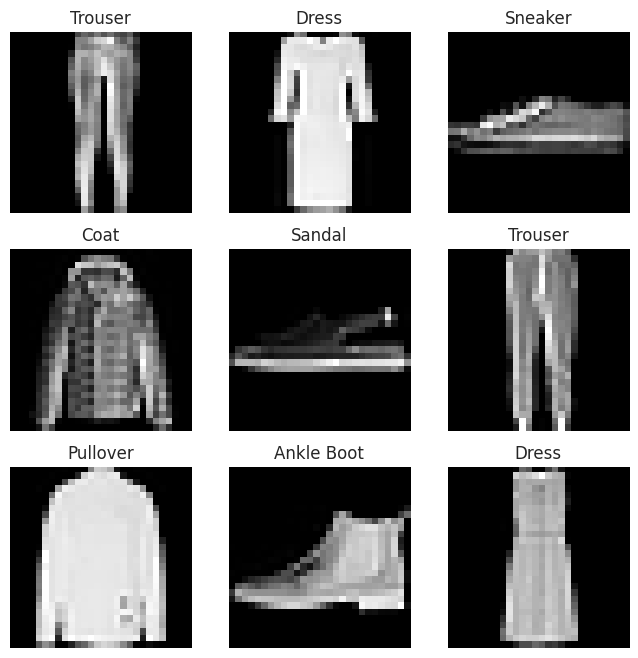


[3] Creating and training NumPy Neural Network...
Training info:

Shape of X [N, C, H, W]: (64, 1, 28, 28), type X: float32
Shape of y: ([(64,)]) int64
Feature batch shape: (64, 1, 28, 28), Feature type: float32
Labels batch shape: (64, 10), Labels type: float32
Testing info:

Shape of X [N, C, H, W]: (64, 1, 28, 28), type X: float32
Shape of y: ([(64,)]) int64

Starting training...
🚀 STARTING TRAINING FOR 200 EPOCHS
EPOCH 1/200
Epoch 1 - Loss: 2.2988383  [   64/60000]
Epoch 1 - Loss: 2.2926382  [ 6464/60000]
Epoch 1 - Loss: 2.2790876  [12864/60000]
Epoch 1 - Loss: 2.2771699  [19264/60000]
Epoch 1 - Loss: 2.2490470  [25664/60000]
Epoch 1 - Loss: 2.2288709  [32064/60000]
Epoch 1 - Loss: 2.2183506  [38464/60000]
Epoch 1 - Loss: 2.2020260  [44864/60000]
Epoch 1 - Loss: 2.1991026  [51264/60000]
Epoch 1 - Loss: 2.1712048  [57664/60000]

📊 Training Epoch 1 Statistics:
   • Loss - Mean: 2.2386005, Median: 2.2417914
   • Loss (reported) - Mean: 2.2416336, Median: 2.2389589
   • Average loss: 

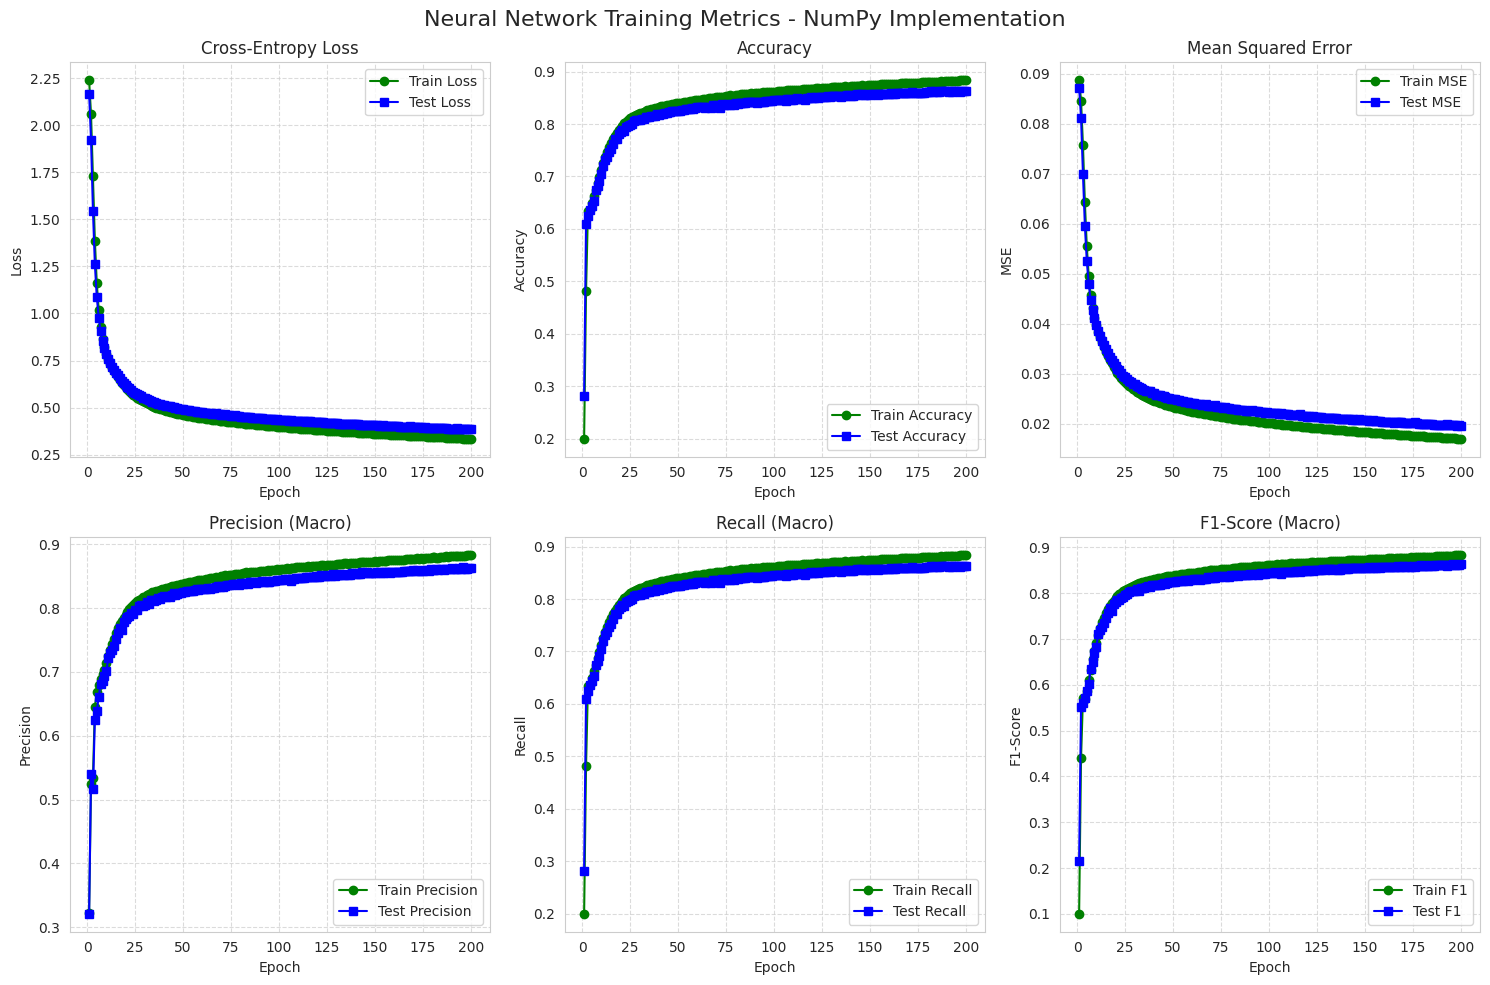

Saved Pickle NumPy Model State to ../models/numpy_model_1.pkl
Saved Joblib NumPy Model State to ../models/numpy_model_1.joblib
Saved Torch NumPy Model State to ../models/numpy_model_1.pth

[4] Plotting training graphs...


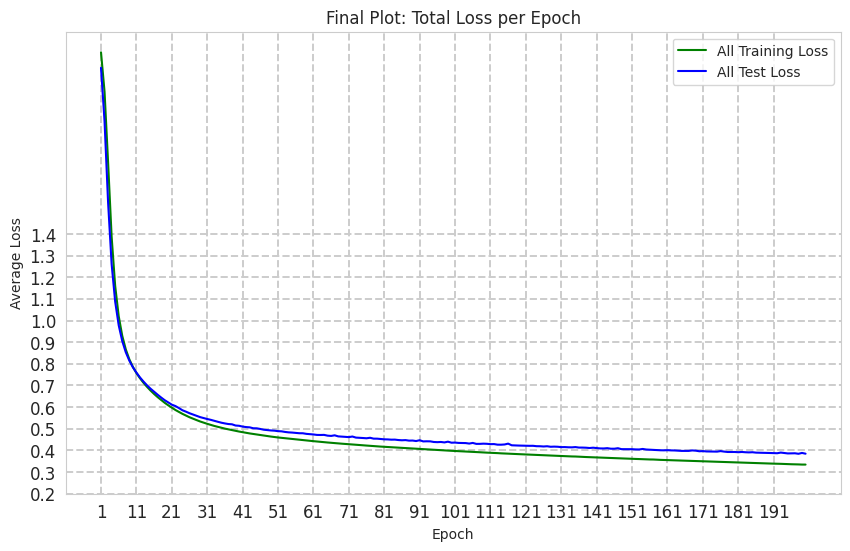

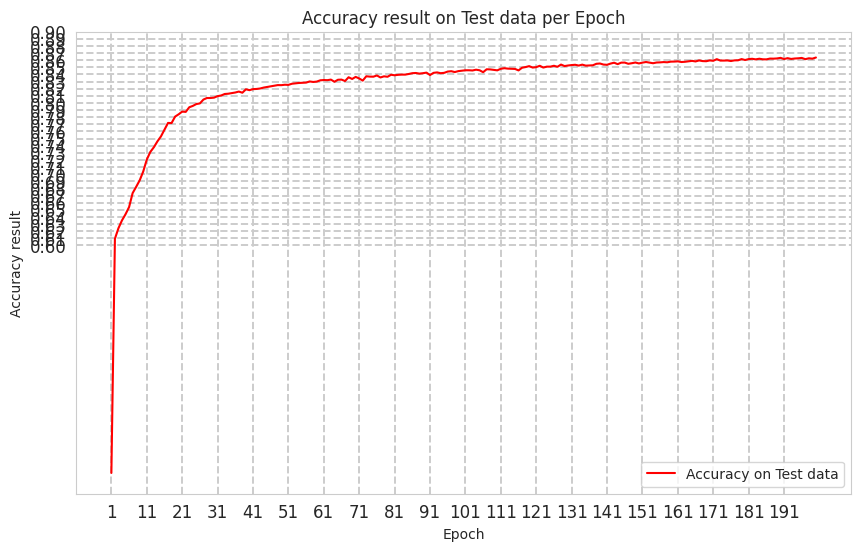


[5] Training PyTorch model for comparison...
PyTorchNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])

🚀 STARTING PYTORCH TRAINING FOR 200 EPOCHS

PYTORCH EPOCH 1/200
Epoch 1 - Loss: 2.306377  [   64/60000]
Epoch 1 - Loss: 2.291045  [ 6464/60000]
Epoch 1 - Loss: 2.283349  [12864/60000]
Epoch 1 - Loss: 2.251130  [19264/60000]
Epoch 1 - Loss: 2.249045  [25664/60000]
Epoch 1 - Loss: 2.226283  [32064/60000]
Epoch 1 - Loss: 2.222932 

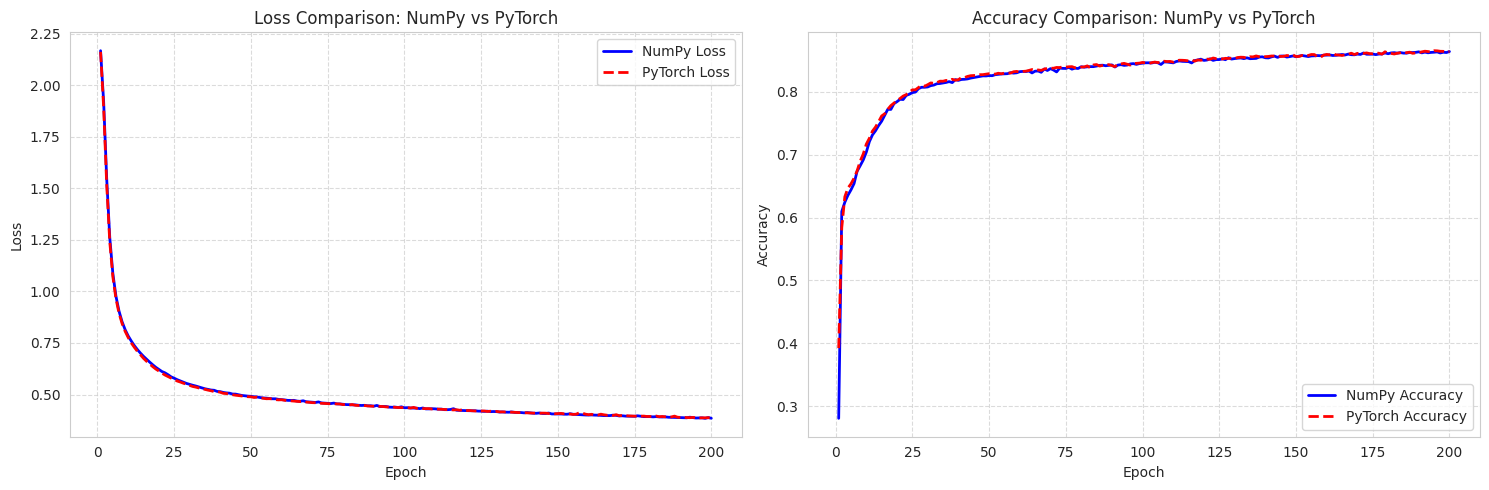

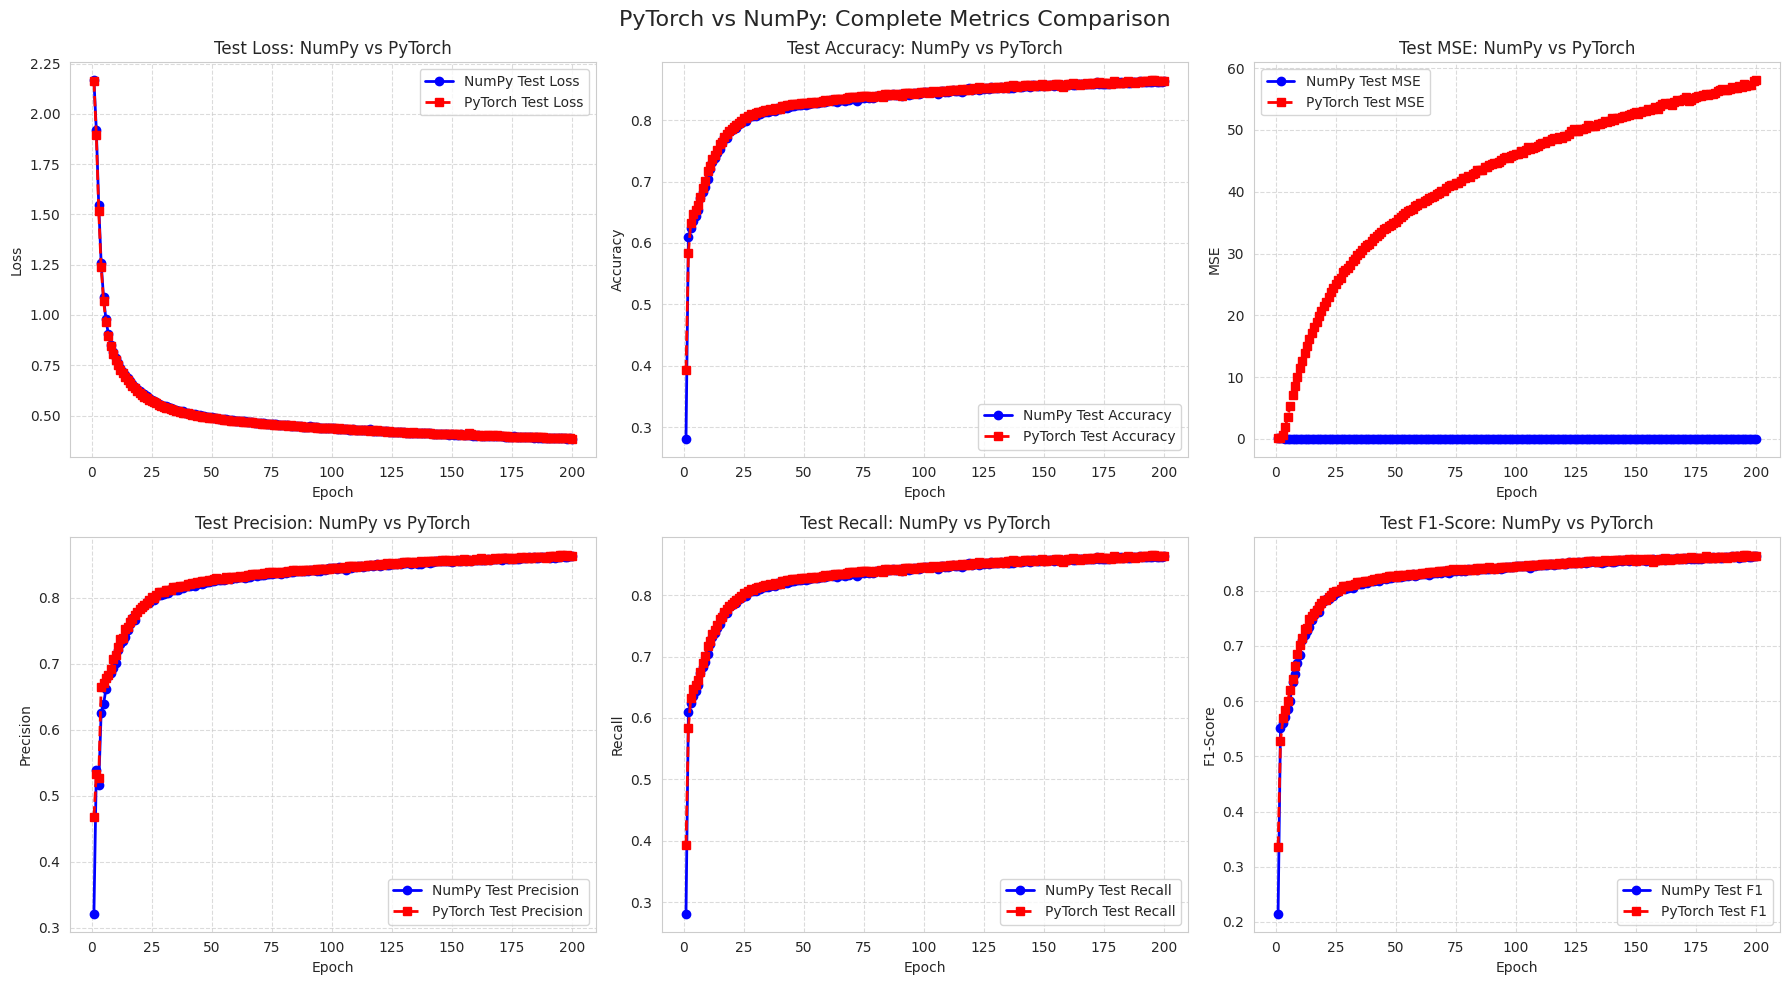


🏆 FINAL COMPARISON - BEST RESULTS
Metric               NumPy                     PyTorch                   Difference     
--------------------------------------------------------------------------------
Test Accuracy        0.86380 (86.4%)         0.86510 (86.5%)         -0.00130
Test Loss (min)      0.38448                  0.38549                  -0.00101
Test F1-Score        0.86329                  0.86440                  -0.00112

[7] Testing single prediction...
Длина test_labels: 10000
Predicted: Dress, Actual: Coat

Total running time of the script: (28 minutes 3.821 seconds)
Script started at: 2026-02-12 13:27:56
Script ended at: 2026-02-12 13:56:00
time.struct_time(tm_year=2026, tm_mon=2, tm_mday=12, tm_hour=13, tm_min=56, tm_sec=0, tm_wday=3, tm_yday=43, tm_isdst=0)


In [290]:
start_time: float = time.time()

print("\n[1] Loading FashionMNIST dataset...")
# Загружаем тренировочный датасет
train_images, train_labels = load_fashion_mnist(
  train=True,
  flatten=True,
  normalize=True
)
# Загружаем тестовый датасет
test_images, test_labels = load_fashion_mnist(
  train=False,
  flatten=True,
  normalize=True
)
if train_images is None or train_labels is None:
  print("Failed to load dataset!")
  exit(-1)

# Выводим данные датасетов - размер, тип и длину
print(f"Train images shape: {train_images.shape}, type: {train_images.dtype}, images_len: {len(train_images)}")
print(f"Train labels shape: {train_labels.shape}, type: {train_labels.dtype}, labels_len: {len(train_labels)}")
print(f"Test images shape: {test_images.shape}, type: {test_images.dtype}, images_len: {len(test_images)}")
print(f"Test labels shape: {test_images.shape}, type: {test_images.dtype}, labels_len: {len(test_images)}")

# Пробуем узнать более подробную информацию о датасете с помощью pandas DataFrame
train_images_df: pd.DataFrame = pd.DataFrame(train_images)
train_labels_df: pd.DataFrame = pd.DataFrame(train_labels, columns=['label'])
test_images_df: pd.DataFrame = pd.DataFrame(test_images)
test_labels_df: pd.DataFrame = pd.DataFrame(test_labels, columns=['label'])

print("Description of training images:")
print(train_images_df.describe())
print("Taking an info of training images:")
print(train_images_df.info())

print("\nDescription of training labels:")
print(train_labels_df.describe())
print("Taking an info of training labels:")
print(train_labels_df.info())

print("\nDescription of test images:")
print(test_images_df.describe())
print("Taking an info of test images:")
print(test_images_df.info())

print("\nDescription of test labels:")
print(test_labels_df.describe())
print("Taking an info of test labels:")
print(test_labels_df.info())

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device: str = "cuda"  # Use GPU if available
    device_name: str = torch.cuda.get_device_name(0)  # Get GPU name
    print(f"Using CUDA device: {device_name}")
else:
    device = "cpu"  # Use CPU if no GPU is available
    print("Using CPU device")

print(f"Using {device} device")

print("\n[2] Displaying random images from dataset...")
display_random_images(train_images, train_labels, labels_map)

print("\n[3] Creating and training NumPy Neural Network...")
# Создание модели
numpy_model: NumpyNeuralNetwork_1 = NumpyNeuralNetwork_1(
    input_size=MY_CONSTANTS.input_size,
    hidden_size=MY_CONSTANTS.hidden_size,
    output_size=MY_CONSTANTS.output_size,
    learning_rate=MY_CONSTANTS.learning_rate
)
print(numpy_model)

# Тренировочный проход (Сборка тренировочного датасета)
train_batches = create_batches(
    train_images,
    train_labels,
    batch_size=MY_CONSTANTS.batch_size
)
# Вывод информации о тренировочной сборке
print("Training info:\n")
for X, y in train_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape}]) {y.dtype}")
    break

# Вывод информации о тренировочных картинках и подписях
train_features, train_labels1 = next(iter(train_batches))
train_labels_one_hot = label_encode(train_labels1)

print(f"Feature batch shape: {train_features.shape}, Feature type: {train_features.dtype}")
print(f"Labels batch shape: {train_labels_one_hot.shape}, Labels type: {train_labels_one_hot.dtype}")

# Тестовый проход (Сборка тестового датасета)
test_batches = create_batches(
    test_images, 
    test_labels, 
    batch_size=MY_CONSTANTS.batch_size
)
# Вывод информации о тестовой сборке
print("Testing info:\n")
for X, y in test_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape}]) {y.dtype}")
    break

# Обучение
print("\nStarting training...")
numpy_metrics: Dict[str, List[float]] = numpy_model.train(
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels,
    epochs=MY_CONSTANTS.epochs,
    batch_size=MY_CONSTANTS.batch_size,
    report_interval=MY_CONSTANTS.report_interval,
    plot_batch_graphs=False
)
print(f"\n✅ Training for NumPy class completed for {MY_CONSTANTS.epochs} epochs!")

# Тестирование
numpy_model.predict(test_images, test_labels)

# Вывод всех графиков
print_all_metrics_graphs(numpy_metrics)

# Сохранение модели
numpy_model.save_model(
    filename_pickle="../models/numpy_model_1.pkl",
    filename_joblib="../models/numpy_model_1.joblib",
    filename_torch="../models/numpy_model_1.pth")
print("\n[4] Plotting training graphs...")
    
# Проверяем, что у нас есть данные для графиков
if len(numpy_model.train_losses) > 0 and len(numpy_model.test_losses) > 0:
    # График loss по эпохам
    print_result_graph(numpy_model.train_losses, numpy_model.test_losses)
    
    # График accuracy
    if len(numpy_model.test_accuracies) > 0:
        print_accuracy_graph(numpy_model.test_accuracies, numpy_model.epochs_completed)
else:
    print("⚠️ No training data to plot!")

print("\n[5] Training PyTorch model for comparison...")

# Загрузка данных через PyTorch DataLoader
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader: DataLoader = DataLoader(
    training_data, 
    batch_size=MY_CONSTANTS.batch_size, 
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_data, 
    batch_size=MY_CONSTANTS.batch_size, 
    shuffle=False
)

# Создание PyTorch модели
pytorch_model = PyTorchNeuralNetwork().to(device)
print(pytorch_model)
loss_fn = nn.CrossEntropyLoss()
print(loss_fn)
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=MY_CONSTANTS.learning_rate)
print(optimizer)

train_features_, train_labels_ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features_.size()}")
print(f"Labels batch shape: {train_labels_.size()}")

# Полное обучение
pytorch_metrics: Dict[str, List[float]] = train_pytorch_full(
    model=pytorch_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=MY_CONSTANTS.epochs,
    batch_size=MY_CONSTANTS.batch_size,
    report_interval=MY_CONSTANTS.report_interval
)

pytorch_model.eval()
length: int = len(labels_map)
if length is not None:
  print(f"Длина labels_map: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = pytorch_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Сравнительные графики
print("\n[6] Plotting comparison graphs...")
compare_with_pytorch(
    numpy_metrics['test_losses'],
    pytorch_metrics['test_losses'],
    numpy_metrics['test_accuracies'],
    pytorch_metrics['test_accuracies'],
)

# Сравнительные графики
compare_pytorch_numpy_graphs(numpy_metrics, pytorch_metrics)

print("\n[7] Testing single prediction...")
length: int = len(test_labels)
if length is not None:
  print(f"Длина test_labels: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
index: int = random.randint(0, len(test_labels) - 1)
numpy_model.single_test(index, test_images, test_labels)

# Конечное время выполнения
end_time: float = time.time()
total_time: float = end_time - start_time
minutes: int = int(total_time // 60)
seconds: float = total_time % 60

print("\n" + "=" * 60)
print(f"Total running time of the script: ({minutes} minutes {seconds:.3f} seconds)")

start_time_formatted: str = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
end_time_formatted: str = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

print(f"Script started at: {start_time_formatted}")
print(f"Script ended at: {end_time_formatted}")

current_time: float = time.time()
local_time: float = time.localtime(current_time)
print(local_time)
print("=" * 60)

## Тест варианта 2


[1] Loading FashionMNIST dataset...
Train images shape: (60000, 784), type: float32, images_len: 60000
Train labels shape: (60000,), type: int64, labels_len: 60000
Test images shape: (10000, 784), type: float32, images_len: 10000
Test labels shape: (10000, 784), type: float32, labels_len: 10000
Description of training images:
                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000003      0.000023      0.000118      0.000407      0.000979   
std        0.000363      0.000977      0.003011      0.009851      0.016986   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.062745      0.141176      

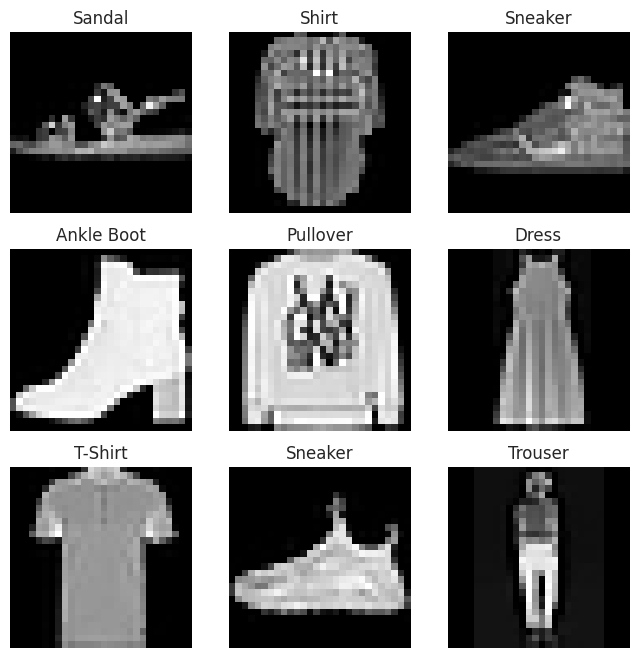


[3] Creating and training NumPy Neural Network...
Training info:

Shape of X [N, C, H, W]: (64, 1, 28, 28), type X: float32
Shape of y: ([(64,)]) int64
Feature batch shape: (64, 1, 28, 28), Feature type: float32
Labels batch shape: (64, 10), Labels type: float32
Testing info:

Shape of X [N, C, H, W]: (64, 1, 28, 28), type X: float32
Shape of y: ([(64,)]) int64

Starting training...
🚀 STARTING TRAINING FOR 200 EPOCHS
EPOCH 1/200
-------------------------------
Epoch 1 - Loss: 2.4199932  [   64/60000]
Epoch 1 - Loss: 1.9428628  [ 6464/60000]
Epoch 1 - Loss: 1.8035443  [12864/60000]
Epoch 1 - Loss: 1.4649915  [19264/60000]
Epoch 1 - Loss: 1.3403670  [25664/60000]
Epoch 1 - Loss: 1.1668006  [32064/60000]
Epoch 1 - Loss: 1.1622237  [38464/60000]
Epoch 1 - Loss: 1.1728596  [44864/60000]
Epoch 1 - Loss: 0.9946528  [51264/60000]
Epoch 1 - Loss: 0.9035602  [57664/60000]

📊 Training Epoch 1 Statistics:
   • Loss - Mean: 1.3988101, Median: 1.2789627
   • Loss (reported) - Mean: 1.4371856, Media

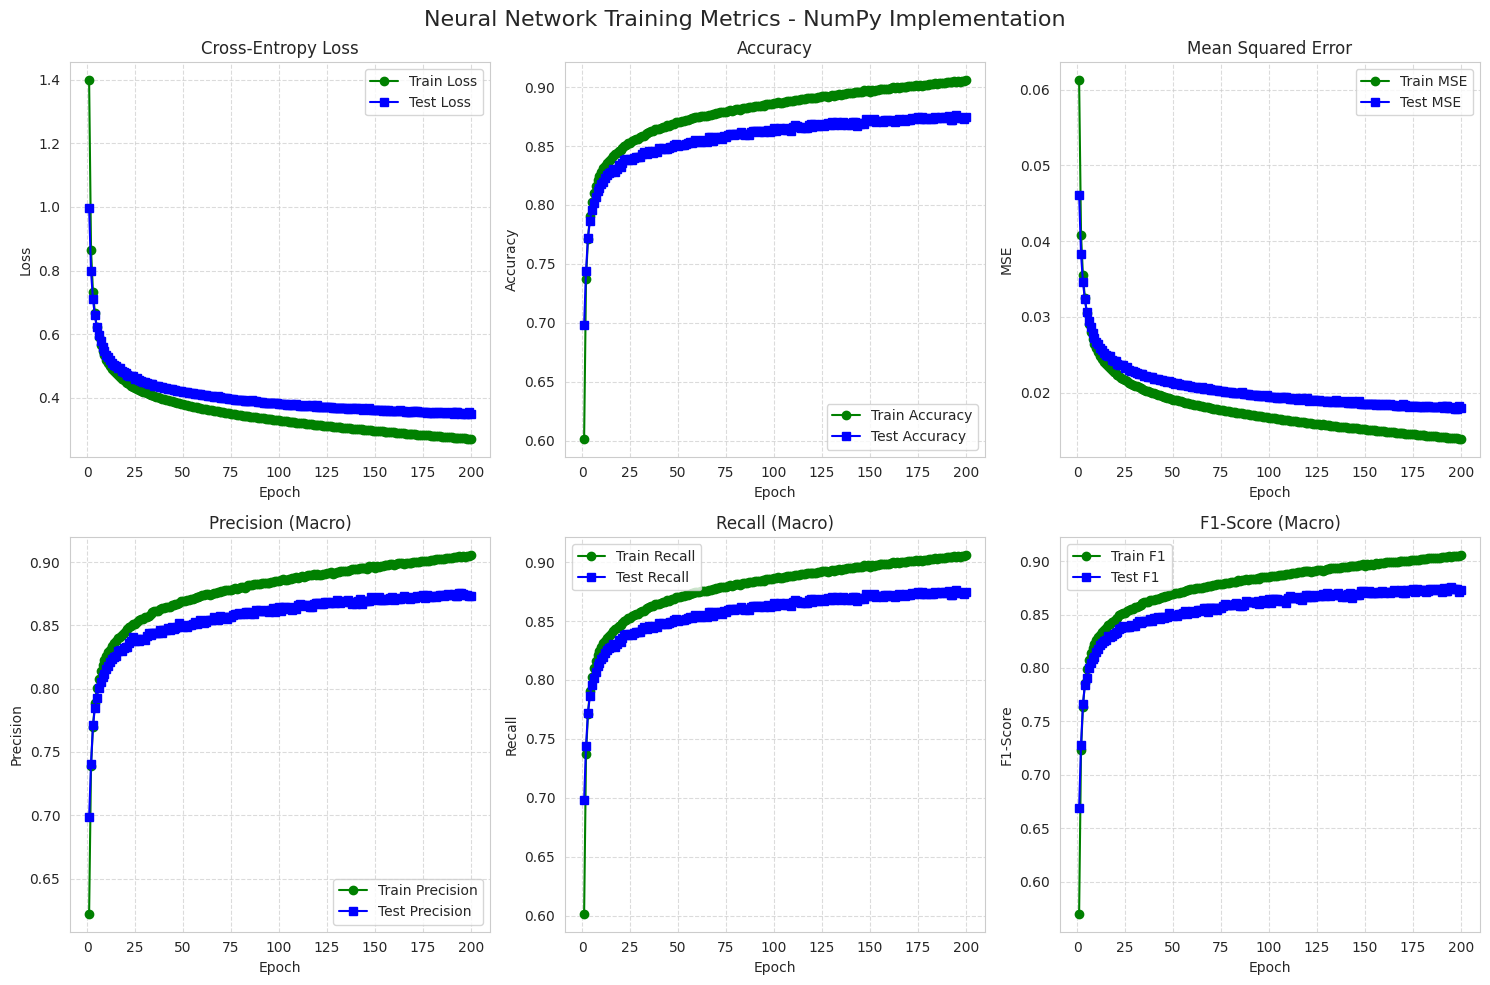

Saved Pickle NumPy Model State to ../models/numpy_model_2.pkl
Saved Joblib NumPy Model State to ../models/numpy_model_2.joblib
Saved Torch NumPy Model State to ../models/numpy_model_2.pth

[4] Plotting training graphs...


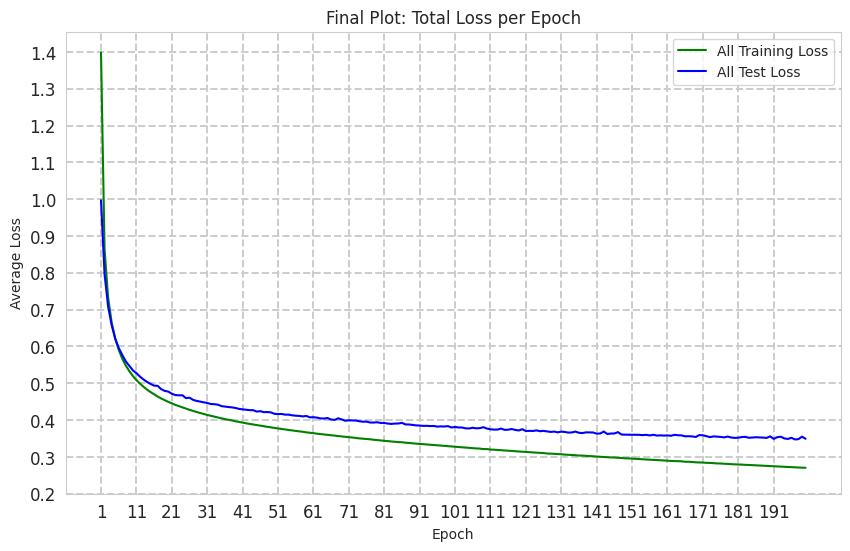

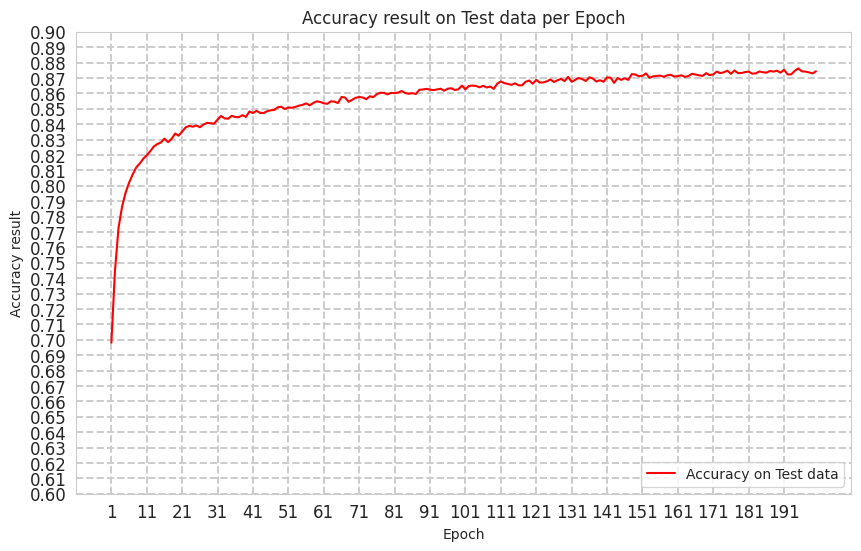


[5] Training PyTorch model for comparison...
PyTorchNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])

🚀 STARTING PYTORCH TRAINING FOR 200 EPOCHS

PYTORCH EPOCH 1/200
Epoch 1 - Loss: 2.295488  [   64/60000]
Epoch 1 - Loss: 2.271322  [ 6464/60000]
Epoch 1 - Loss: 2.263090  [12864/60000]
Epoch 1 - Loss: 2.255029  [19264/60000]
Epoch 1 - Loss: 2.225404  [25664/60000]
Epoch 1 - Loss: 2.217363  [32064/60000]
Epoch 1 - Loss: 2.195591 

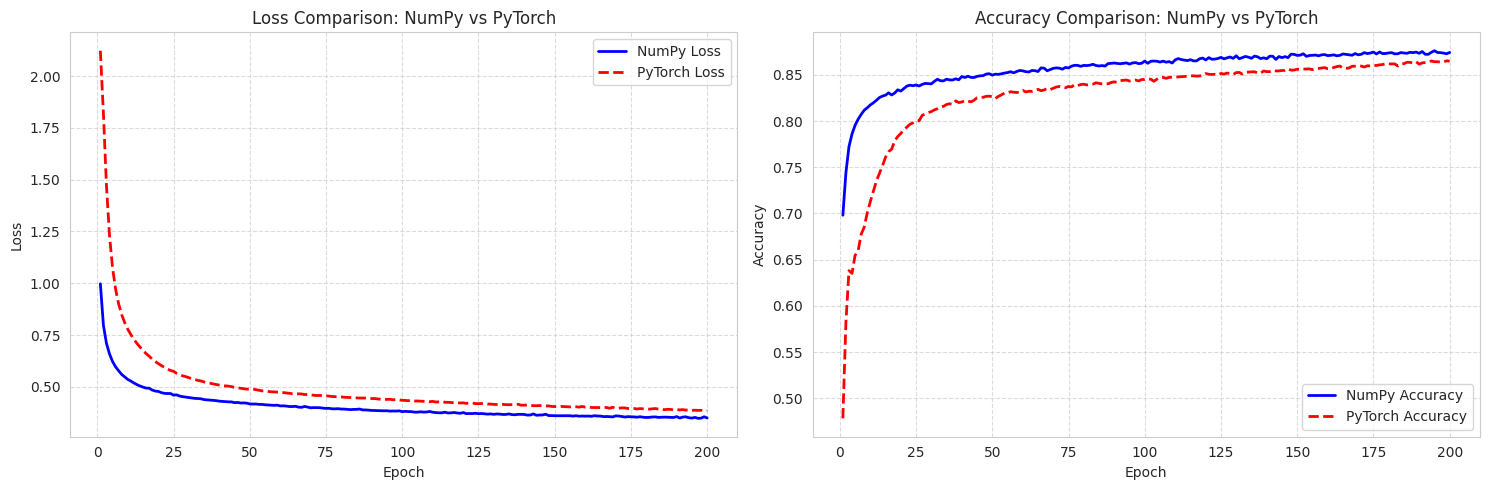

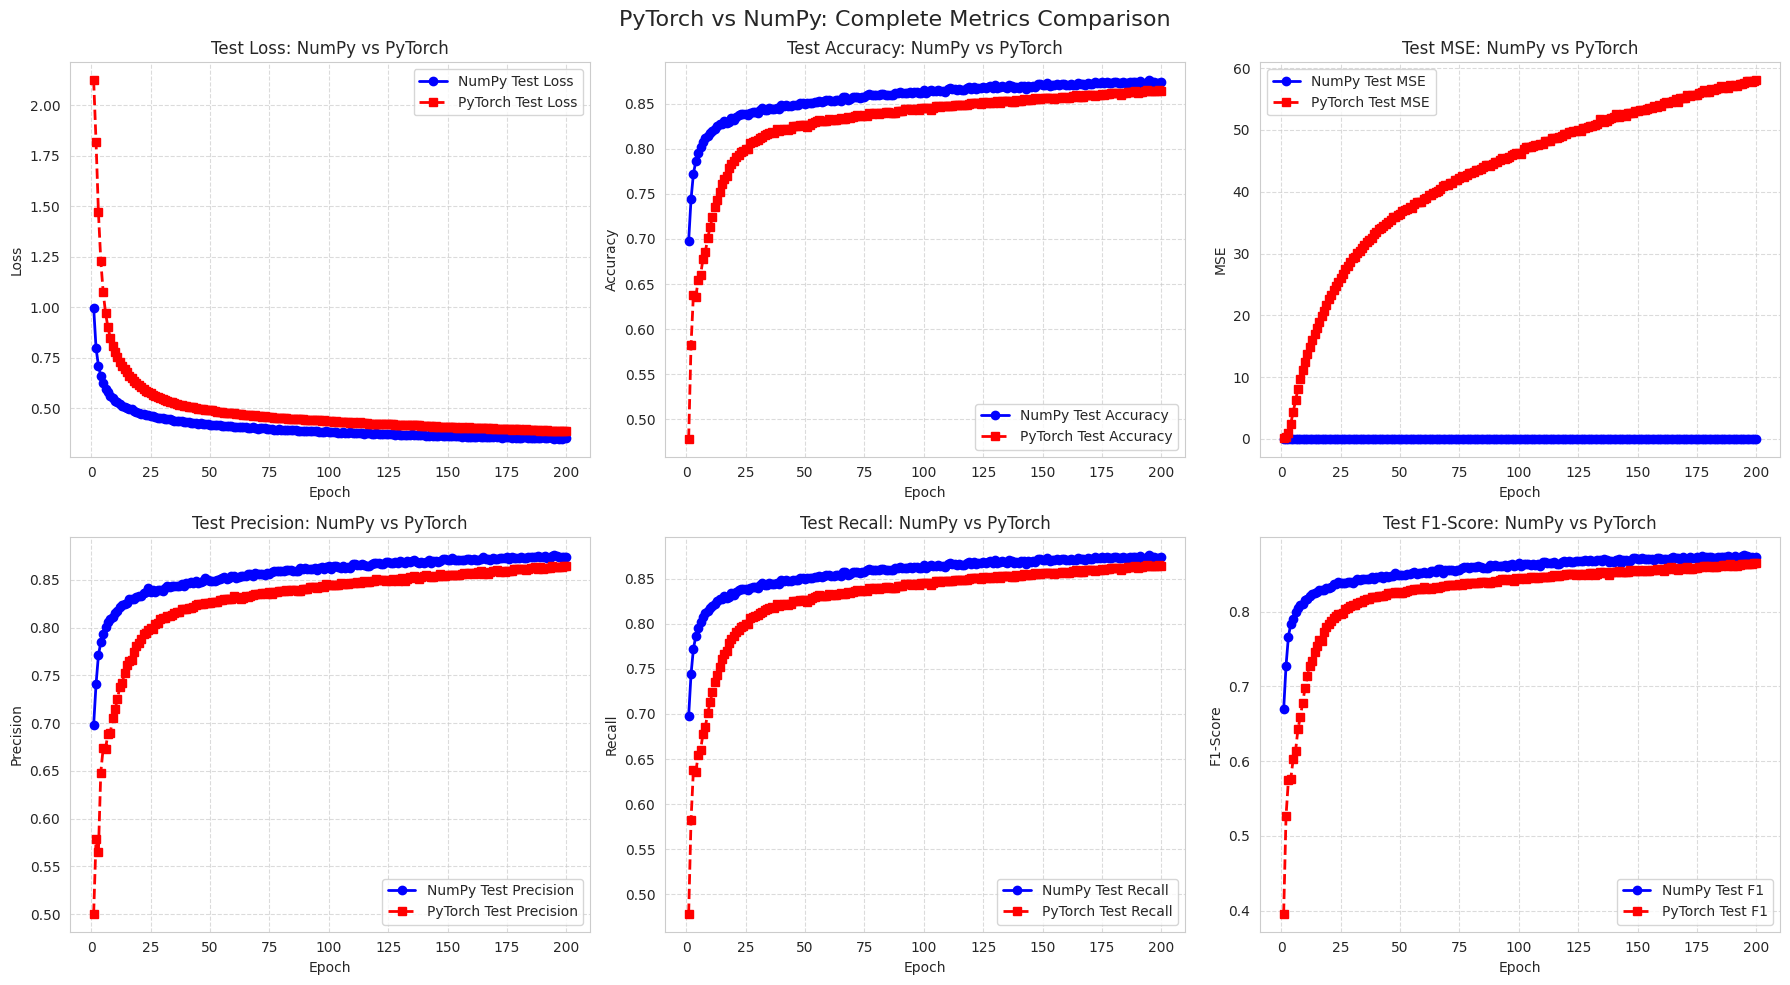


🏆 FINAL COMPARISON - BEST RESULTS
Metric               NumPy                     PyTorch                   Difference     
--------------------------------------------------------------------------------
Test Accuracy        0.87620 (87.6%)         0.86530 (86.5%)         +0.01090
Test Loss (min)      0.34749                  0.38491                  -0.03742
Test F1-Score        0.87551                  0.86480                  +0.01071

[7] Testing single prediction...
Длина test_labels: 10000
Predicted: T-Shirt, Actual: T-Shirt

Total running time of the script: (22 minutes 29.936 seconds)
Script started at: 2026-02-12 11:32:27
Script ended at: 2026-02-12 11:54:57
time.struct_time(tm_year=2026, tm_mon=2, tm_mday=12, tm_hour=11, tm_min=54, tm_sec=57, tm_wday=3, tm_yday=43, tm_isdst=0)


In [257]:
start_time: float = time.time()

print("\n[1] Loading FashionMNIST dataset...")
# Загружаем тренировочный датасет
train_images, train_labels = load_fashion_mnist(
  train=True,
  flatten=True,
  normalize=True
)
# Загружаем тестовый датасет
test_images, test_labels = load_fashion_mnist(
  train=False,
  flatten=True,
  normalize=True
)
if train_images is None or train_labels is None:
  print("Failed to load dataset!")
  exit(-1)

# Выводим данные датасетов - размер, тип и длину
print(f"Train images shape: {train_images.shape}, type: {train_images.dtype}, images_len: {len(train_images)}")
print(f"Train labels shape: {train_labels.shape}, type: {train_labels.dtype}, labels_len: {len(train_labels)}")
print(f"Test images shape: {test_images.shape}, type: {test_images.dtype}, images_len: {len(test_images)}")
print(f"Test labels shape: {test_images.shape}, type: {test_images.dtype}, labels_len: {len(test_images)}")

# Пробуем узнать более подробную информацию о датасете с помощью pandas DataFrame
train_images_df = pd.DataFrame(train_images)
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_images_df = pd.DataFrame(test_images)
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

print("Description of training images:")
print(train_images_df.describe())
print("Taking an info of training images:")
print(train_images_df.info())

print("\nDescription of training labels:")
print(train_labels_df.describe())
print("Taking an info of training labels:")
print(train_labels_df.info())

print("\nDescription of test images:")
print(test_images_df.describe())
print("Taking an info of test images:")
print(test_images_df.info())

print("\nDescription of test labels:")
print(test_labels_df.describe())
print("Taking an info of test labels:")
print(test_labels_df.info())

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device: str = "cuda"  # Use GPU if available
    device_name: str = torch.cuda.get_device_name(0)  # Get GPU name
    print(f"Using CUDA device: {device_name}")
else:
    device = "cpu"  # Use CPU if no GPU is available
    print("Using CPU device")

print(f"Using {device} device")

print("\n[2] Displaying random images from dataset...")
display_random_images(train_images, train_labels, labels_map)

print("\n[3] Creating and training NumPy Neural Network...")
# Создание модели
numpy_model = NumpyNeuralNetwork_2(
    input_size=MY_CONSTANTS.input_size,
    hidden_size=MY_CONSTANTS.hidden_size,
    output_size=MY_CONSTANTS.output_size,
    learning_rate=MY_CONSTANTS.learning_rate
)
print(numpy_model)

# Тренировочный проход (Сборка тренировочного датасета)
train_batches = create_batches(
    train_images,
    train_labels,
    batch_size=MY_CONSTANTS.batch_size
)
# Вывод информации о тренировочной сборке
print("Training info:\n")
for X, y in train_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape}]) {y.dtype}")
    break

# Вывод информации о тренировочных картинках и подписях
train_features, train_labels1 = next(iter(train_batches))
train_labels_one_hot = label_encode(train_labels1)

print(f"Feature batch shape: {train_features.shape}, Feature type: {train_features.dtype}")
print(f"Labels batch shape: {train_labels_one_hot.shape}, Labels type: {train_labels_one_hot.dtype}")

# Тестовый проход (Сборка тестового датасета)
test_batches = create_batches(
    test_images, 
    test_labels, 
    batch_size=MY_CONSTANTS.batch_size
)
# Вывод информации о тестовой сборке
print("Testing info:\n")
for X, y in test_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape}]) {y.dtype}")
    break

# Обучение
print("\nStarting training...")
numpy_metrics = numpy_model.train(
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels,
    epochs=MY_CONSTANTS.epochs,
    batch_size=MY_CONSTANTS.batch_size,
    report_interval=MY_CONSTANTS.report_interval,
    plot_batch_graphs=False
)
print(f"\n✅ Training for NumPy class completed for {MY_CONSTANTS.epochs} epochs!")

# Тестирование
numpy_model.predict(test_images, test_labels)

# Вывод всех графиков
print_all_metrics_graphs(numpy_metrics)

# Сохранение модели
numpy_model.save_model(
    filename_pickle="../models/numpy_model_2.pkl",
    filename_joblib="../models/numpy_model_2.joblib",
    filename_torch="../models/numpy_model_2.pth"
)

print("\n[4] Plotting training graphs...")
    
# Проверяем, что у нас есть данные для графиков
if len(numpy_model.train_losses) > 0 and len(numpy_model.test_losses) > 0:
    # График loss по эпохам
    print_result_graph(numpy_model.train_losses, numpy_model.test_losses)
    
    # График accuracy
    if len(numpy_model.test_accuracies) > 0:
        print_accuracy_graph(numpy_model.test_accuracies, numpy_model.epochs_completed)
else:
    print("⚠️ No training data to plot!")

print("\n[5] Training PyTorch model for comparison...")

# Загрузка данных через PyTorch DataLoader
training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader: DataLoader = DataLoader(
    training_data, 
    batch_size=MY_CONSTANTS.batch_size, 
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_data, 
    batch_size=MY_CONSTANTS.batch_size, 
    shuffle=False
)

# Создание PyTorch модели
pytorch_model = PyTorchNeuralNetwork().to(device)
print(pytorch_model)
loss_fn = nn.CrossEntropyLoss()
print(loss_fn)
optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=MY_CONSTANTS.learning_rate)
print(optimizer)

train_features_, train_labels_ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features_.size()}")
print(f"Labels batch shape: {train_labels_.size()}")

# Полное обучение
pytorch_metrics = train_pytorch_full(
    model=pytorch_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=MY_CONSTANTS.epochs,
    batch_size=MY_CONSTANTS.batch_size,
    report_interval=MY_CONSTANTS.report_interval
)

pytorch_model.eval()
length = len(labels_map)
if length is not None:
  print(f"Длина labels_map: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = pytorch_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Сравнительные графики
print("\n[6] Plotting comparison graphs...")
compare_with_pytorch(
    numpy_metrics['test_losses'],
    pytorch_metrics['test_losses'],
    numpy_metrics['test_accuracies'],
    pytorch_metrics['test_accuracies'],
)

# Сравнительные графики
compare_pytorch_numpy_graphs(numpy_metrics, pytorch_metrics)

print("\n[7] Testing single prediction...")
length = len(test_labels)
if length is not None:
  print(f"Длина test_labels: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
index = random.randint(0, len(test_labels) - 1)
numpy_model.single_test(index, test_images, test_labels)

# Конечное время выполнения
end_time: float = time.time()
total_time: float = end_time - start_time
minutes: int = int(total_time // 60)
seconds: float = total_time % 60

print("\n" + "=" * 60)
print(f"Total running time of the script: ({minutes} minutes {seconds:.3f} seconds)")

start_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
end_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

print(f"Script started at: {start_time_formatted}")
print(f"Script ended at: {end_time_formatted}")

current_time = time.time()
local_time = time.localtime(current_time)
print(local_time)
print("=" * 60)